In [1]:
import nltk
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re
import copy
import difflib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import learning_curve, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from mlxtend.evaluate import paired_ttest_5x2cv
# import the snowball stemmer which is more complex than porter
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\Katherine
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Katherine
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Katherine
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Katherine Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Import Dataset

In [3]:
movies_df = pd.read_csv('wiki_movie_plots_deduped.csv')
movies_df.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."


In [4]:
# Continuous Feature - Release Year

def buildContinuousFeaturesReport(features, data_df):
    conHead = ['Count', 'Miss %', 'Card.', 'Min', '1st Qrt.',
            'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']

    conOut_df = pd.DataFrame(index=features, columns=conHead)
    columns_df = data_df[features]

    #COUNT
    conOut_df[conHead[0]] = len(columns_df)

    #MISS % 
    conOut_df[conHead[1]] = columns_df.isna().sum() / len(columns_df) * 100

    #CARDINALITY
    conOut_df[conHead[2]] = columns_df.nunique()

    #MINIMUM
    conOut_df[conHead[3]] = columns_df.min()

    #1ST QUARTILE
    conOut_df[conHead[4]] = columns_df.quantile(0.25)

    #MEAN
    conOut_df[conHead[5]] = columns_df.mean()

    #MEDIAN
    conOut_df[conHead[6]] = columns_df.median()

    #3rd QUARTILE
    conOut_df[conHead[7]] = columns_df.quantile(0.75)

    #MAX
    conOut_df[conHead[8]] = columns_df.max()

    #STANDARD DEVIATION
    conOut_df[conHead[9]] = columns_df.std()

    return conOut_df

In [5]:
with pd.option_context('display.float_format', '{:.2f}'.format):
      display(buildContinuousFeaturesReport(movies_df.select_dtypes('number').columns.to_list(), movies_df))

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Release Year,34886,0.00,117,1901,1957.00,1981.31,1988.00,2007.00,2017,27.82


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BDA46E940>]],
      dtype=object)

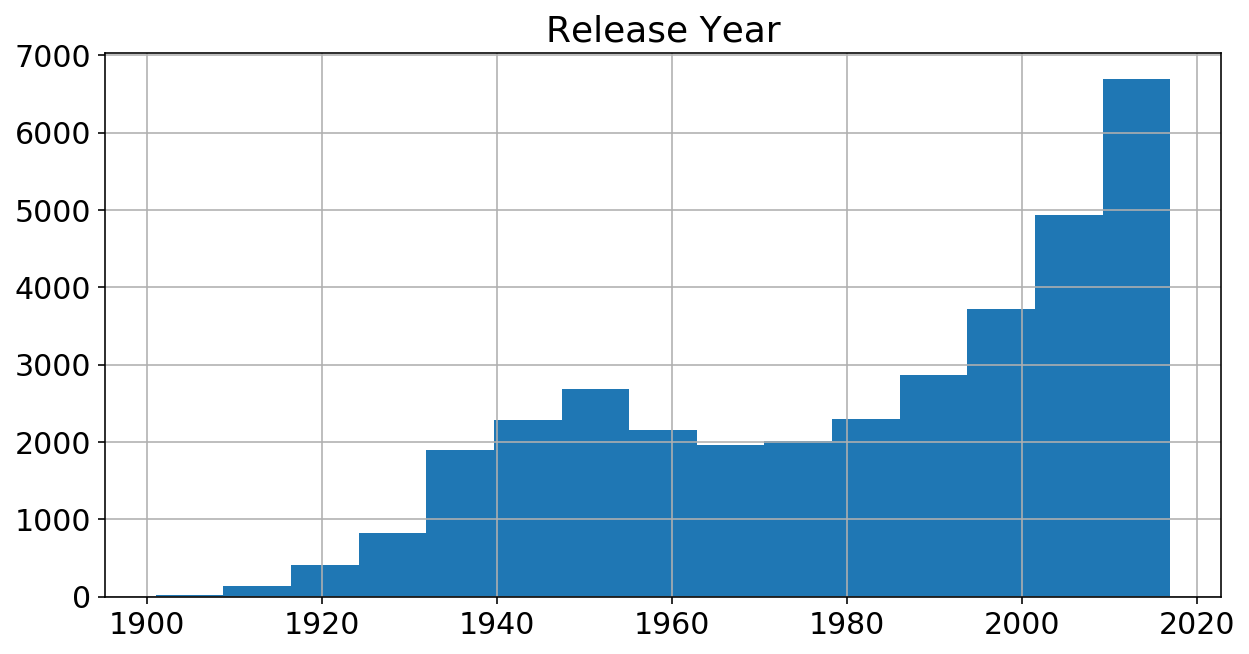

In [6]:
# Histogram Visualization

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

movies_df.select_dtypes('number').hist(bins = 15)

**Comment**: From 1901 to 2017, the amount of movies produced each year were constantly increasing. There are 2 spikes from the graph, on is between 1940 to 1960 after WWII the economy is getting better. Also from after 1960 to 2017, the production showed an exponential growth. This might be explained as the improvement of people's living standrads, people's demand for the cultural and entertainment industry was greatly increasing.

#### As a plot of a movie is not a categorical feature, a general data quality report does not provide a lot of insights. Therefore, we will substitute the actual text items with their properties such as:
*   Text length
*   The number of words
*   Presence of non-alphanumeric characters
*   The number of words after stopwords removal

In [7]:
def properties(feature, movies_df):
    properties_df = pd.DataFrame()
    text_length = np.array([])
    word_count = np.array([])
    non_alphanumeric_count = np.array([])
    filtered_word_count = np.array([])
    
    for text in movies_df[feature]:
        text = text.lower()

        #Text length (count characters)
        text_length = np.append(text_length, len(text))

        #The number of words
        word_count = np.append(word_count, len(text.split()))

        #Presence of non-alphanumeric characters (punctuation characters, special characters) (except white space)
        pattern = "[a-zA-Z0-9\s]*"
        text_copy = copy.copy(text)
        text_copy = re.sub(pattern, '',text_copy)
        non_alphanumeric_count = np.append(non_alphanumeric_count, len(text_copy))

        #Any additional properties that you find useful in understanding text
        #Number of words after stopwords removal
        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(text) 
        # filter out stop word tokens
        filtered_plot = [w for w in word_tokens if not w in stop_words]
        filtered_word_count = np.append(filtered_word_count, len(filtered_plot))

    properties_df['Title'] = movies_df['Title'].to_numpy()
    properties_df['Text Length'] = text_length
    properties_df['Word Count'] = word_count
    properties_df['Non-alphanumeric Count'] = non_alphanumeric_count
    properties_df['Word Count (w/o stopwords)'] = filtered_word_count

    return properties_df

In [8]:
properties('Plot', movies_df)

,Title,Text Length,Word Count,Non-alphanumeric Count,Word Count (w/o stopwords)
0,Kansas Saloon Smashers,500.0,83.0,15.0,64.0
1,Love by the Light of the Moon,437.0,86.0,13.0,57.0
2,The Martyred Presidents,436.0,76.0,18.0,56.0
3,"Terrible Teddy, the Grizzly King",890.0,153.0,29.0,113.0
4,Jack and the Beanstalk,732.0,140.0,17.0,88.0
...,...,...,...,...,...
34881,The Water Diviner,3492.0,591.0,100.0,434.0
34882,Çalgı Çengi İkimiz,75.0,11.0,4.0,10.0
34883,Olanlar Oldu,388.0,67.0,14.0,47.0
34884,Non-Transferable,1141.0,193.0,54.0,165.0


### Data Quality Plan
* remove rows with non-english plot
* remove columns that are not so useful or has lots of missing values (e.g. wiki page link, cast)
* remove non-alphanumeric characters in textual features (i.e punctuations)
* rename column names for simplier reference
* translate titles with non english words (tried to use Google Cloud Translation API, but it is not free)
* classify movie genres
* tokenize textual features
* removing stopwords
* lemmatize/stemming

### Data Preprocessing

In [9]:
# Check language for Plots
from langdetect import detect
movies_df['Plot Language'] = movies_df['Plot'].apply(detect)

In [10]:
movies_df.groupby('Plot Language').groups

{'en': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], 'id': [25016, 25398, 28376], 'pt': [6210], 'sw': [33727]}

**Comment:** We can see that most of the plot language is English, we can either drop the rows which the plots are not in English or translate them into English. Since we have a large enough dataset for plots in English, we will drop the ones that are not for simplification. However, it will be more useful to translate when there are a large portion of datasets are in different languages.

In [11]:
movies_df = movies_df.drop(movies_df[movies_df['Plot Language'] != 'en'].index)

In [12]:
# Drop cast director and wiki page feature
movies_df = movies_df.drop(['Cast', 'Wiki Page', 'Director'], axis = 1)

In [13]:
# Rename columns
movies_df = movies_df.rename(columns = {'Release Year':'Year', 
                                        'Origin/Ethnicity':'Origin'
                                       })

In [14]:
movies_df['Plot'].head()

0    A bartender is working at a saloon, serving dr...
1    The moon, painted with a smiling face hangs ov...
2    The film, just over a minute long, is composed...
3    Lasting just 61 seconds and consisting of two ...
4    The earliest known adaptation of the classic f...
Name: Plot, dtype: object

In [15]:
# Replace all non-alphanumeric characters in textual features
movies_df.Origin = movies_df.Origin.str.replace('\d+', '') # for digits
movies_df.Origin = movies_df.Origin.str.replace(r'(\b\w{1,2}\b)', '') # for words
movies_df.Origin = movies_df.Origin.str.replace('[^\w\s]', '') # for punctuation 

movies_df.Title = movies_df.Title.str.replace('\d+', '') # for digits
movies_df.Title = movies_df.Title.str.replace(r'(\b\w{1,2}\b)', '') # for words
movies_df.Title = movies_df.Title.str.replace('[^\w\s]', '') # for punctuation 

movies_df.Plot = movies_df.Plot.str.replace('\d+', '') # for digits
movies_df.Plot = movies_df.Plot.str.replace(r'(\b\w{1,2}\b)', '') # for words
movies_df.Plot = movies_df.Plot.str.replace('[^\w\s]', '') # for punctuation 

movies_df.Genre = movies_df.Genre.str.replace('\d+', '') # for digits
movies_df.Genre = movies_df.Genre.str.replace(r'(\b\w{1,2}\b)', '') # for words
movies_df.Genre = movies_df.Genre.str.replace('[^\w\s]', '') # for punctuation 

In [16]:
properties('Plot', movies_df)

,Title,Text Length,Word Count,Non-alphanumeric Count,Word Count (w/o stopwords)
0,Kansas Saloon Smashers,464.0,72.0,0.0,48.0
1,Love the Light the Moon,395.0,69.0,0.0,44.0
2,The Martyred Presidents,384.0,57.0,0.0,41.0
3,Terrible Teddy the Grizzly King,815.0,127.0,0.0,84.0
4,Jack and the Beanstalk,661.0,112.0,0.0,71.0
...,...,...,...,...,...
34876,The Water Diviner,3210.0,499.0,3.0,340.0
34877,Çalgı Çengi İkimiz,70.0,10.0,1.0,7.0
34878,Olanlar Oldu,362.0,57.0,5.0,38.0
34879,NonTransferable,1006.0,157.0,0.0,105.0


Since the translation of Titles are not successful and contains non-English information, we will drop the Title column

In [17]:
# Drop cast director and wiki page feature
movies_df = movies_df.drop(['Title'], axis = 1)

We would like to see the proportion of movies in the dataset here, it will tell us information on whether the dataset is balanced and if the genres are known.

In [18]:
# make a dataframe to hold proportion of each genre
genre_df = pd.DataFrame((movies_df.Genre.value_counts()/len(movies_df))*100)
genre_df = genre_df.rename(columns = {'Genre':'Proportion'})
genre_df

,Proportion
unknown,17.433560
drama,17.089533
comedy,12.554113
horror,3.351395
action,3.147846
...,...
action war adventure,0.002867
action history,0.002867
animation music,0.002867
action drama family comedy,0.002867


Here, we could see that the 17% of the genre is unknown, we could either drop the set or we could categorize it all into drama type. However, it could make the dataset more imbalanced.
Also we could see that there are types of movies that consititute a combination of genres, therefore, we could use similarity matching to categorize them into one of the 6 main genres (drama, comedy, romance, western, adventure, sci-fi and horror)

In [19]:
# drop unknown category
# drop row if Genre == unknown
movies_df['Genre'] = movies_df['Genre'].replace('unknown',np.nan)
movies_df = movies_df.dropna(axis=0, subset=['Genre'])
movies_df = movies_df.reset_index(drop=True)

### Fuzzy Matching using difflib

Return a list of the best “good enough” matches. word is a sequence for which close matches are desired (typically a string), and possibilities is a list of sequences against which to match word (typically a list of strings).

In [20]:
comedy_list = difflib.get_close_matches('comedy',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
comedy_list

['comedy',
 'comedy ',
 'comedey',
 'warcomedy',
 'spycomedy',
 'scicomedy',
 'war comedy',
 'teencomedy',
 'spy comedy',
 'sex comedy',
 'sci comedy',
 'pow comedy',
 'comedy war',
 'comedy spy',
 'comedy sci',
 'wuxiacomedy',
 'teen comedy',
 'sci  comedy',
 'heistcomedy',
 'dramacomedy',
 'dark comedy',
 'comedydrama',
 'comedycrime',
 'comedy teen',
 'comedy road',
 'comedy film',
 'comedy cult',
 'comedy  sci',
 'adultcomedy',
 'wuxia comedy',
 'sportscomedy',
 'socialcomedy',
 'short comedy',
 'kung  comedy',
 'horrorcomedy',
 'drama comedy',
 'crime comedy',
 'comedysocial',
 'comedysatire',
 'comedyhorror',
 'comedyfamily',
 'comedyaction',
 'comedy short',
 'comedy drama',
 'comedy crime',
 'comedy adult',
 'black comedy',
 'adult comedy',
 'actioncomedy',
 'zombie comedy',
 'westerncomedy',
 'tragic comedy',
 'sports comedy',
 'social comedy',
 'satire comedy',
 'romancecomedy',
 'period comedy',
 'musicalcomedy',
 'horror comedy',
 'fantasycomedy',
 'family comedy',
 'erotic

In [21]:
# Comedy
comedy_list = difflib.get_close_matches('comedy',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
for item in comedy_list:
    for i in range(len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'comedy')

In [22]:
romance_list = difflib.get_close_matches('romance',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.7)
romance_list

['romance',
 'romance ',
 'warromance',
 'sciromance',
 'romantic',
 'war romance',
 'sci romance',
 'romanceteen',
 'romanceroad',
 'romance war',
 'romance sci',
 'romancedrama',
 'romancecrime',
 'dramaromance',
 'crimeromance',
 'race',
 'youth romance',
 'romancehorror',
 'romanceaction',
 'romance wuxia',
 'romance sport',
 'romance music',
 'romance drama',
 'romance crime',
 'drama romance',
 'dance romance',
 'crime romance',
 'adult romance',
 'actionromance']

In [23]:
# romance
romance_list = difflib.get_close_matches('romance',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.7)
# put these into romance catagory
for item in romance_list:
    for i in range(len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'romance')

In [24]:
western_list = difflib.get_close_matches('western',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
western_list

['western',
 'western ',
 'western war',
 'war western',
 'sci western',
 'epic western',
 'western drama',
 'drama western',
 'crime western',
 'westernromance',
 'western serial',
 'western horror',
 'horror western',
 'family western',
 'action western',
 'western romance',
 'western mystery',
 'western musical',
 'musical western',
 'comedy  western',
 'western thriller',
 'thriller western']

In [25]:
# western
western_list = difflib.get_close_matches('western',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
# put these into western catagory
for item in western_list:
    for i in range(0,len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'western')

In [26]:
adventure_list = difflib.get_close_matches('adventure',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
adventure_list

['adventure',
 'adventures',
 'adventure ',
 'dramaadventure',
 'crimeadventure',
 'adventure film',
 'horroradventure',
 'familyadventure',
 'drama adventure',
 'crime adventure',
 'comedyadventure',
 'adventurecomedy',
 'adventurebiopic',
 'adventure music',
 'adventure drama',
 'actionadventure',
 'romanceadventure',
 'fantasyadventure',
 'family adventure',
 'drama  adventure',
 'comedy adventure',
 'adventureromance',
 'adventure serial',
 'adventure horror',
 'adventure family',
 'adventure drama ',
 'adventure comedy',
 'adventure action',
 'action adventure',
 'mystery adventure',
 'musical adventure',
 'fantasy adventure',
 'comedy  adventure',
 'animatedadventure',
 'african adventure',
 'adventurethriller',
 'adventure romance',
 'adventure mystery',
 'adventure fantasy',
 'adventure  comedy',
 'action  adventure',
 'thriller adventure',
 'romantic adventure',
 'nature',
 'fantasy  adventure',
 'colonial adventure',
 'children adventure',
 'animated adventure',
 'adventure t

In [27]:
# adventure
adventure_list = difflib.get_close_matches('adventure',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
# put these into adventure catagory
for item in adventure_list:
    for i in range(0,len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'adventure')

In [28]:
horror_list = difflib.get_close_matches('horror',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
horror_list

['horror',
 'horror ',
 'scihorror',
 'horrorsci',
 'war horror',
 'sci horror',
 'horror sci',
 'horror film',
 'dramahorror',
 'adulthorror',
 'horroraction',
 'horror spoof',
 'horror drama',
 'drama horror',
 'crime horror',
 'adult horror',
 'actionhorror',
 'zombie horror',
 'parody horror',
 'mysteryhorror',
 'horrorslasher',
 'horror masala',
 'horror family',
 'horror action',
 'horror  drama',
 'erotic horror',
 'action horror',
 'vampire horror',
 'thrillerhorror',
 'mystery horror',
 'horrorthriller',
 'horror slasher',
 'horror romance',
 'horror mystery',
 'horror musical',
 'horror fantasy',
 'fantasy horror']

In [29]:
# Horror
horror_list = difflib.get_close_matches('horror',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.6)
# put these into horror catagory
for item in horror_list:
    for i in range(0,len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'horror')

In [30]:
drama_list = difflib.get_close_matches('drama',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.7)
drama_list

['drama',
 'drama ',
 'wardrama',
 'spydrama',
 'sexdrama',
 'scidrama',
 'biodrama',
 'war drama',
 'spy drama',
 'sci drama',
 'melodrama',
 'lgbtdrama',
 'dramaroad',
 'dramanoir',
 'dramacult',
 'drama war',
 'docudrama']

In [31]:
# Drama
drama_list = difflib.get_close_matches('drama',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.7)
# put these into drama catagory
for item in drama_list:
    for i in range(len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'drama')

In [32]:
scifi_list = difflib.get_close_matches('science fiction',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.65)
scifi_list

['science fiction',
 'sciencefiction',
 'war science fiction',
 'science fiction film',
 'epic science fiction',
 'science fictioncomedy',
 'science fictionaction',
 'science fiction drama',
 'science fiction anime',
 'drama science fiction',
 'anime science fiction',
 'sciencefictiondrama',
 'science fictionmusical',
 'science fictionfantasy',
 'science fiction horror',
 'science fiction family',
 'science fiction comedy',
 'science fiction action',
 'horror science fiction',
 'family science fiction',
 'comedy science fiction',
 'action science fiction',
 'science fiction mystery',
 'fantasy science fiction',
 'action  science fiction',
 'sciencefiction comedy',
 'drama  sciencefiction',
 'science fiction thriller',
 'science fiction animated',
 'disaster science fiction',
 'children science fiction',
 'action  sciencefiction',
 'science fiction adventure',
 'adventure science fiction',
 'sciencefiction thriller',
 'sci action',
 'science fiction time travel',
 'science fiction actio

In [33]:
# Sci-fi
scifi_list = difflib.get_close_matches('science fiction',np.unique(movies_df.Genre.to_list()), n=200, cutoff=0.65)
# put these into adventure catagory
for item in scifi_list:
    for i in range(len(movies_df)):
        if item == movies_df.Genre[i]:
            movies_df.Genre = movies_df.Genre.replace([movies_df.Genre[i]],'scifi')

In [34]:
# make a dataframe to hold proportion of each genre
genre_df = pd.DataFrame((movies_df.Genre.value_counts()/len(movies_df))*100)
genre_df = genre_df.rename(columns = {'Genre':'Proportion'})
genre_df

,Proportion
comedy,21.642361
drama,21.506944
horror,4.427083
romance,4.225694
action,3.812500
...,...
family romance action,0.003472
action adventure drama musical family,0.003472
mysteryaction,0.003472
thrillerromance,0.003472


In [35]:
movies_cleaned_df = movies_df[(movies_df.Genre == ('drama'))]

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('comedy'))])

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('romance'))])

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('western'))])

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('adventure'))])

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('horror'))])

movies_cleaned_df = movies_cleaned_df.append(movies_df[(movies_df.Genre == ('scifi'))])

movies_cleaned_df = movies_cleaned_df.reset_index(drop=True)

In [36]:
# make a dataframe to hold proportion of each genre
genre_df = pd.DataFrame((movies_cleaned_df.Genre.value_counts()/len(movies_cleaned_df))*100)
genre_df = genre_df.rename(columns = {'Genre':'Proportion'})
genre_df

,Proportion
comedy,36.422603
drama,36.194706
horror,7.450476
romance,7.111553
western,5.317595
adventure,4.259919
scifi,3.243148


### Data Understanding

#### Origin

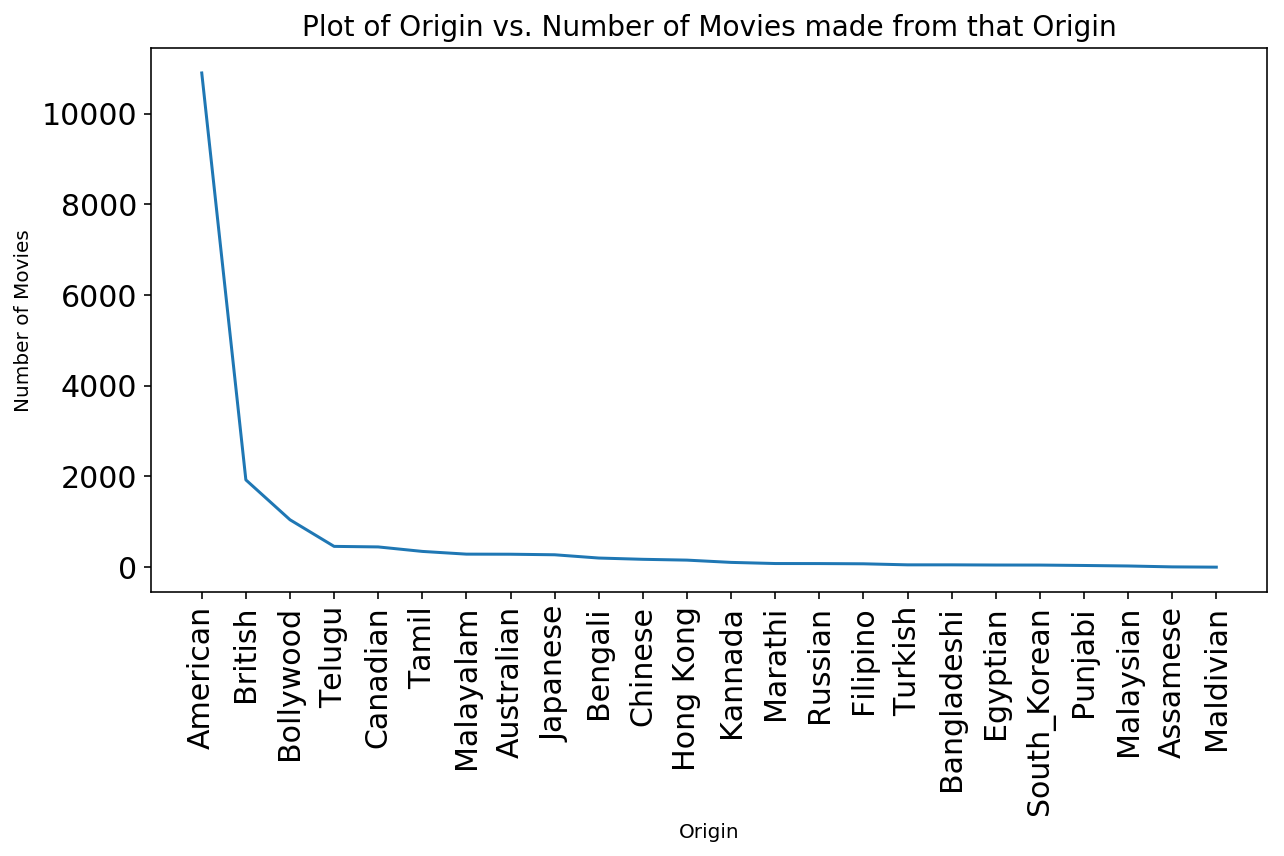

In [37]:
#most common origin & least origin

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.plot(movies_cleaned_df.Origin.value_counts())
plt.title('Plot of Origin vs. Number of Movies made from that Origin', fontsize=14)
plt.xlabel('Origin', fontsize=10)
plt.ylabel('Number of Movies', fontsize=10)
plt.xticks(rotation=90)
plt.show()

#### Top Words in Each Genre

In [38]:
drama_df = pd.DataFrame()
comedy_df = pd.DataFrame()
adventure_df = pd.DataFrame()
romance_df = pd.DataFrame()
western_df = pd.DataFrame()
horror_df = pd.DataFrame()
scifi_df = pd.DataFrame()

for i in range(len(movies_cleaned_df)):
    row = movies_cleaned_df.loc[i]
    if movies_cleaned_df['Genre'][i] == 'drama':
    # append row to drama_df
        drama_df = drama_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'comedy':
    # append row to comedy_df
        comedy_df = comedy_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'adventure':
    # append row to adventure_df
        adventure_df = adventure_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'romance':
    # append row to romance_df
        romance_df = romance_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'western':
    # append row to western_df
        western_df = western_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'scifi':
        scifi_df = scifi_df.append(row)
    elif movies_cleaned_df['Genre'][i] == 'horror':
        horror_df = horror_df.append(row)
    else:
        none

In [39]:
def top_n_words(n,feature,df):
    words = ""
    for plot in df[feature]:
        words += plot + "\n"
    words = words.lower()

  # word_tokenize
    word_tokens = word_tokenize(words)

  # remove stopwords
    stop_words = set(stopwords.words('english')) 
    filtered = [w for w in word_tokens if not w in stop_words]

  # count
    fdist = FreqDist(filtered)
    top_list = fdist.most_common(n)

    return top_list

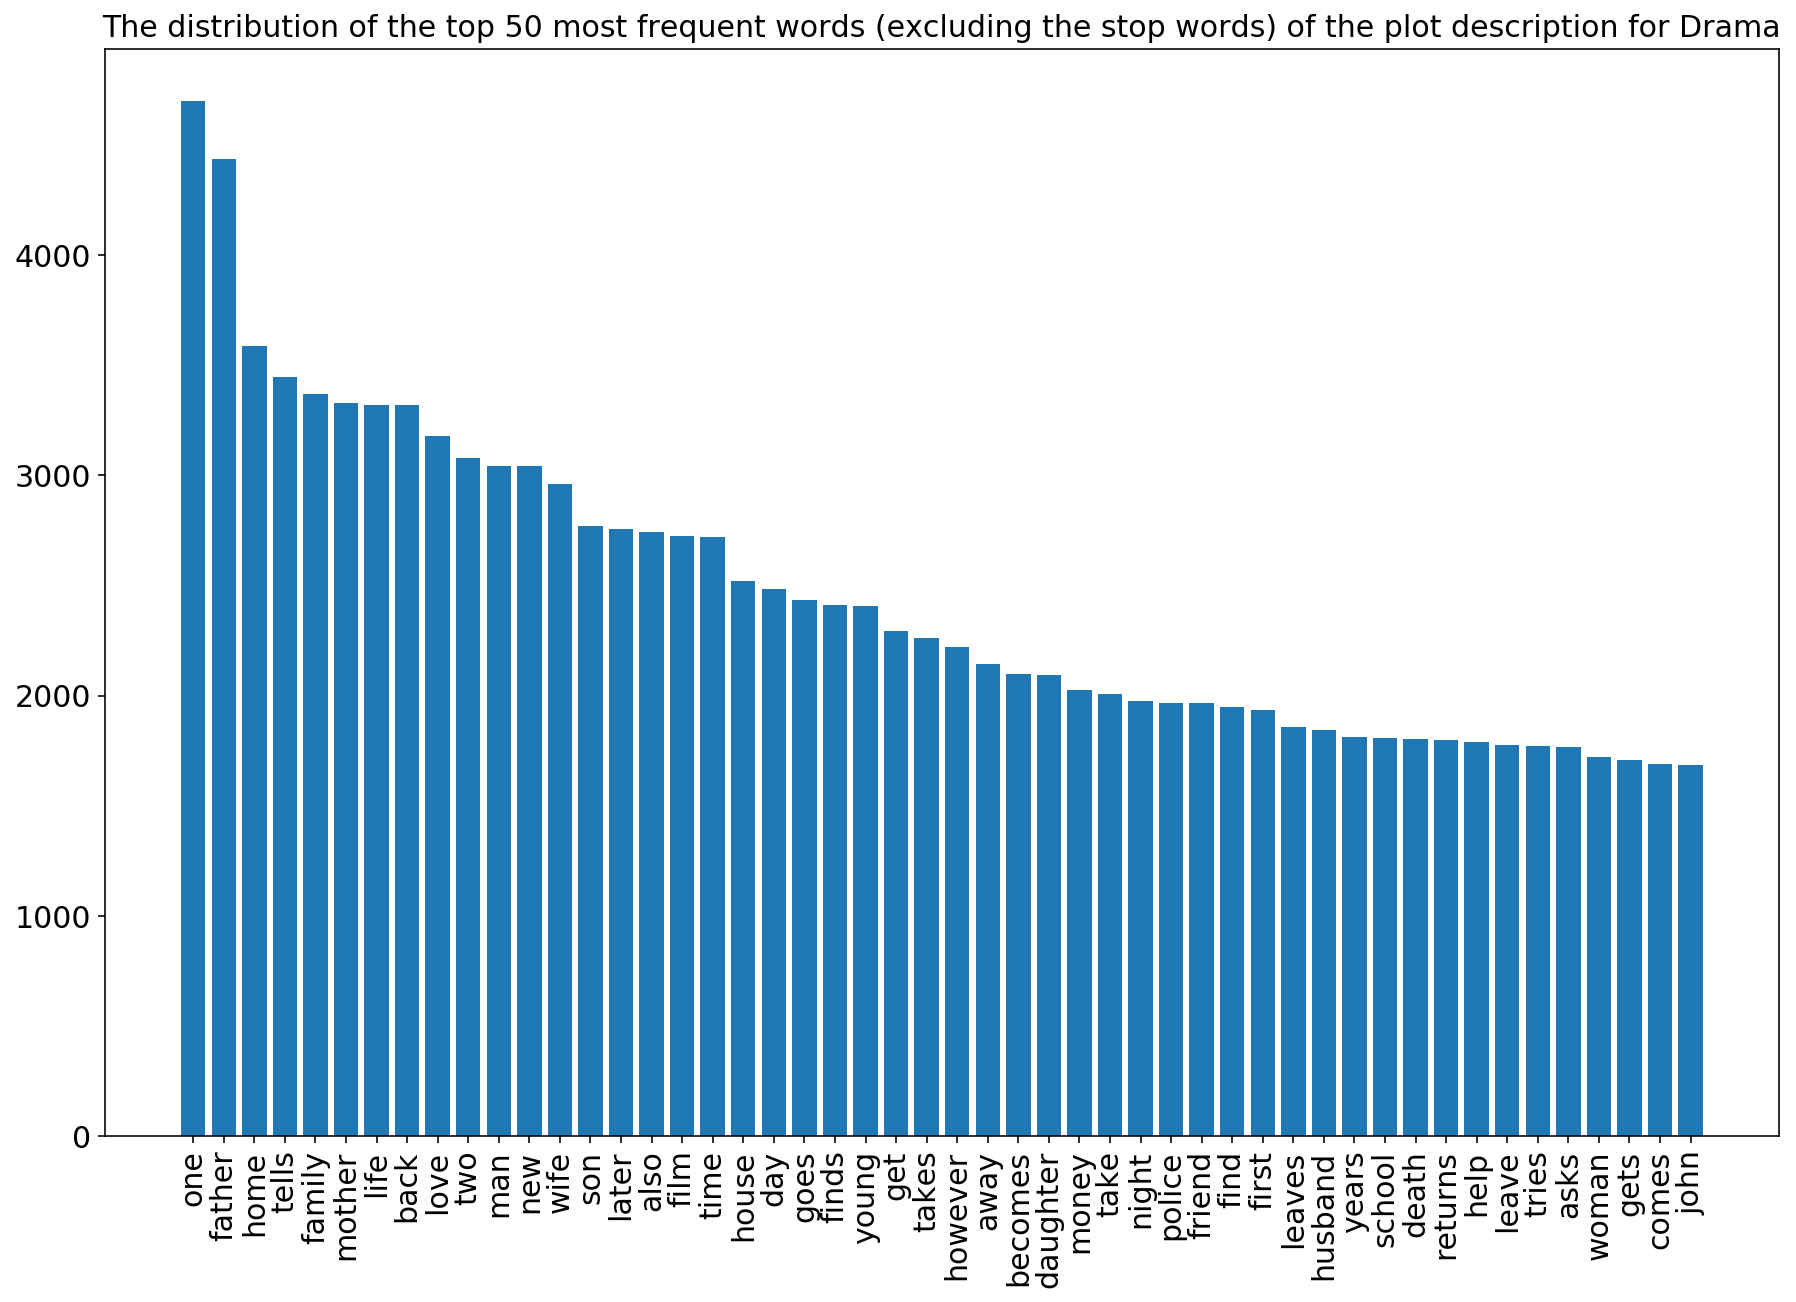

In [40]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',drama_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Drama', fontsize=15)
plt.xticks(rotation=90)
plt.show()

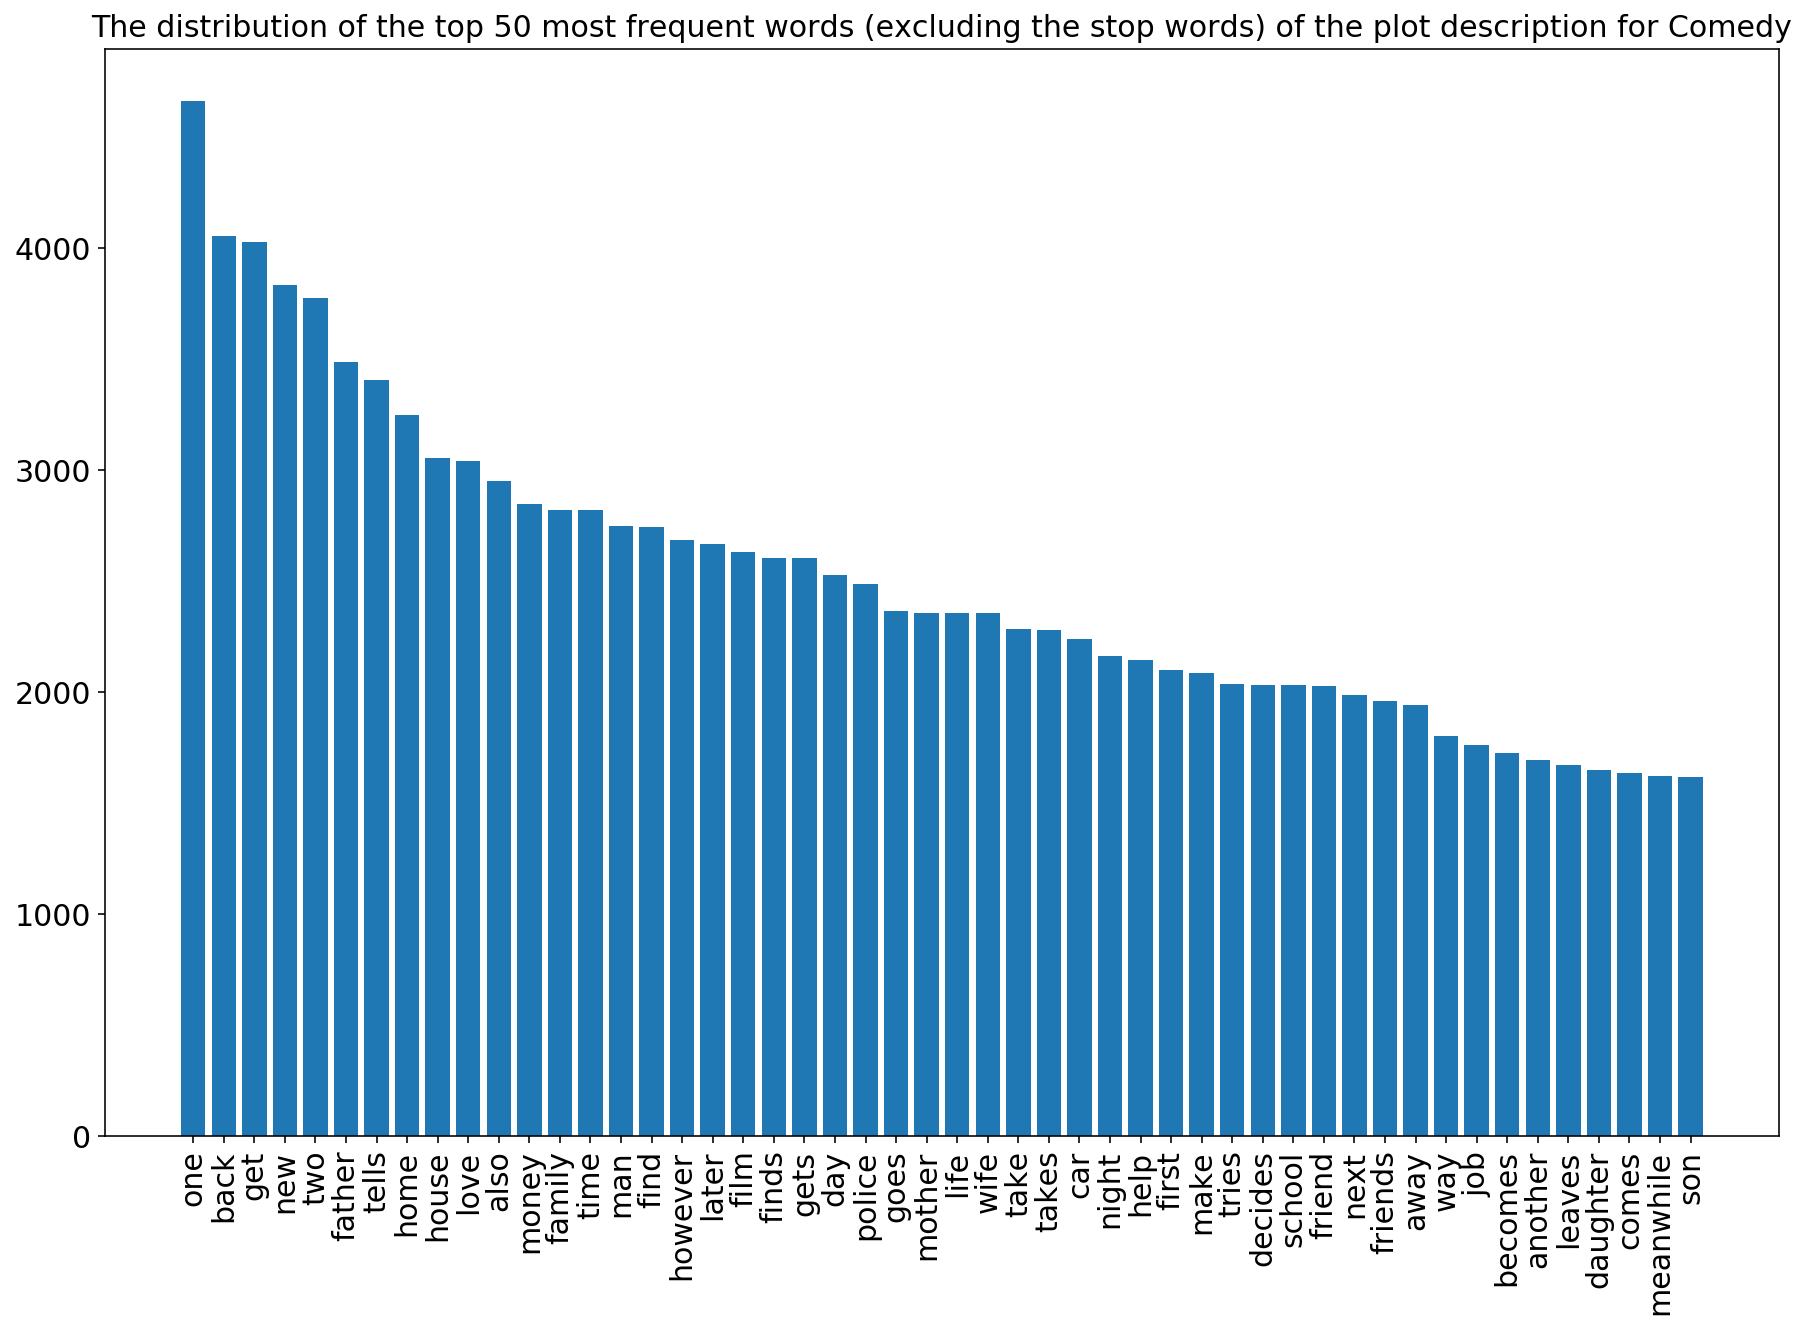

In [41]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',comedy_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Comedy', fontsize=15)
plt.xticks(rotation=90)
plt.show()

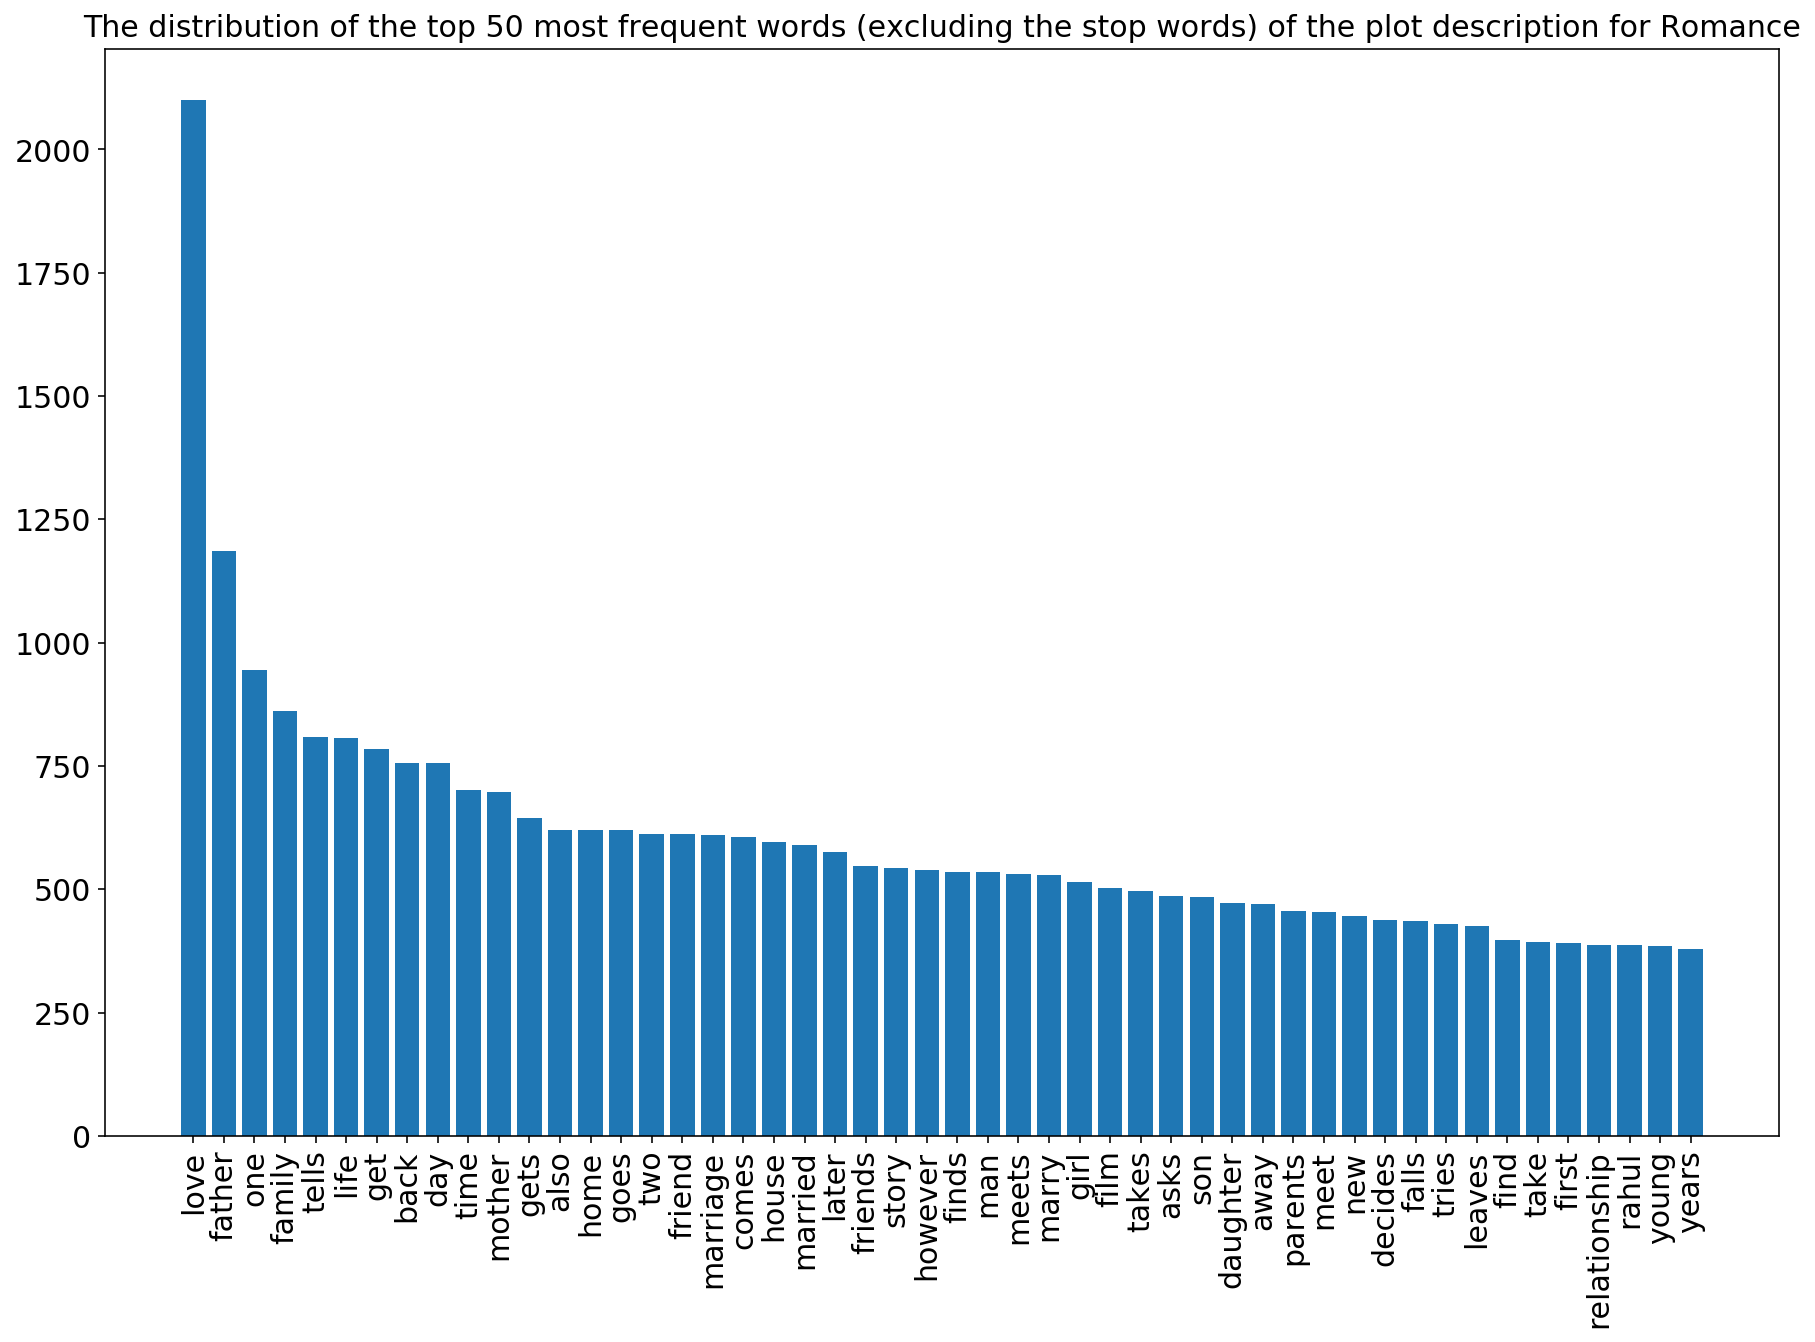

In [42]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',romance_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Romance', fontsize=15)
plt.xticks(rotation=90)
plt.show()

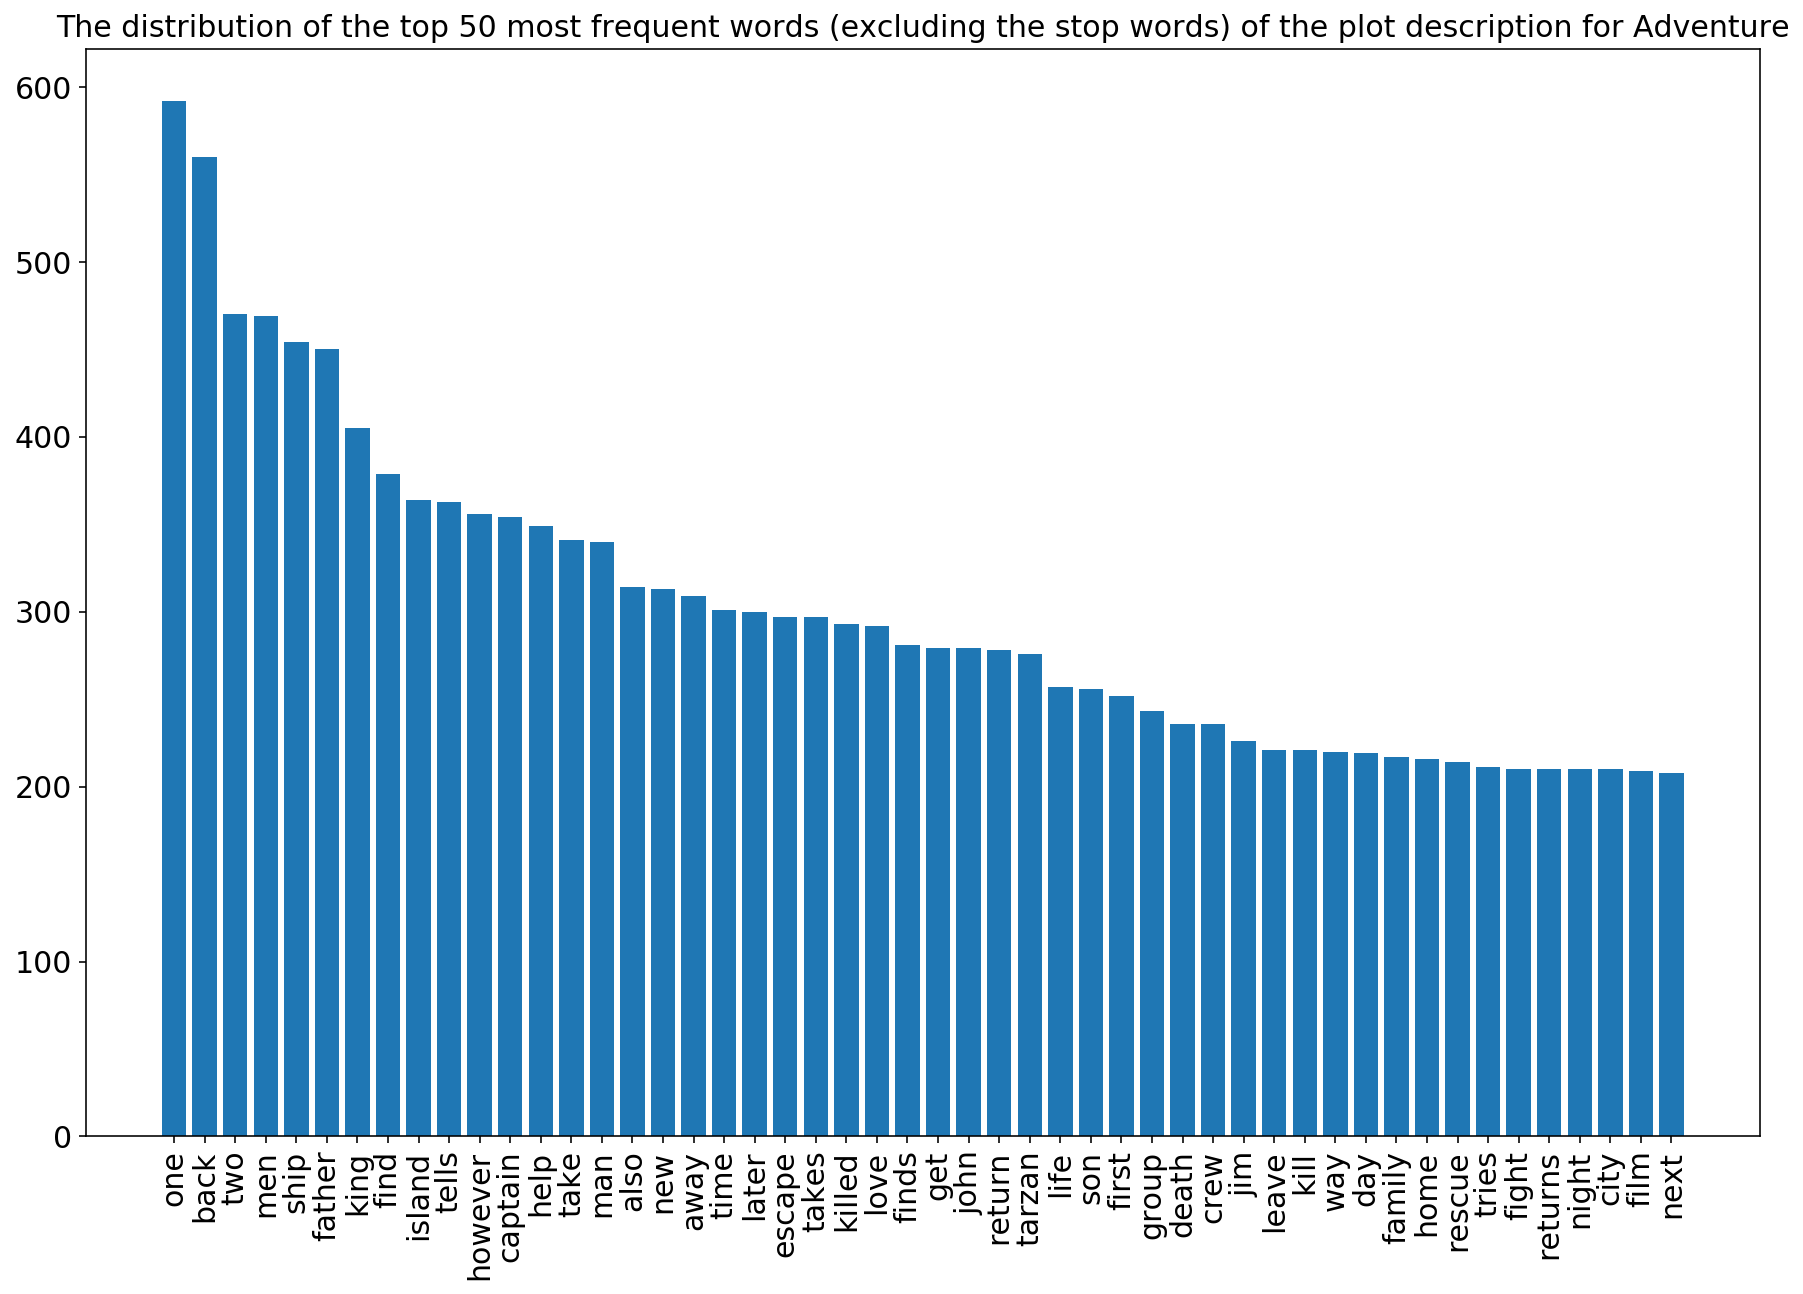

In [43]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',adventure_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Adventure', fontsize=15)
plt.xticks(rotation=90)
plt.show()

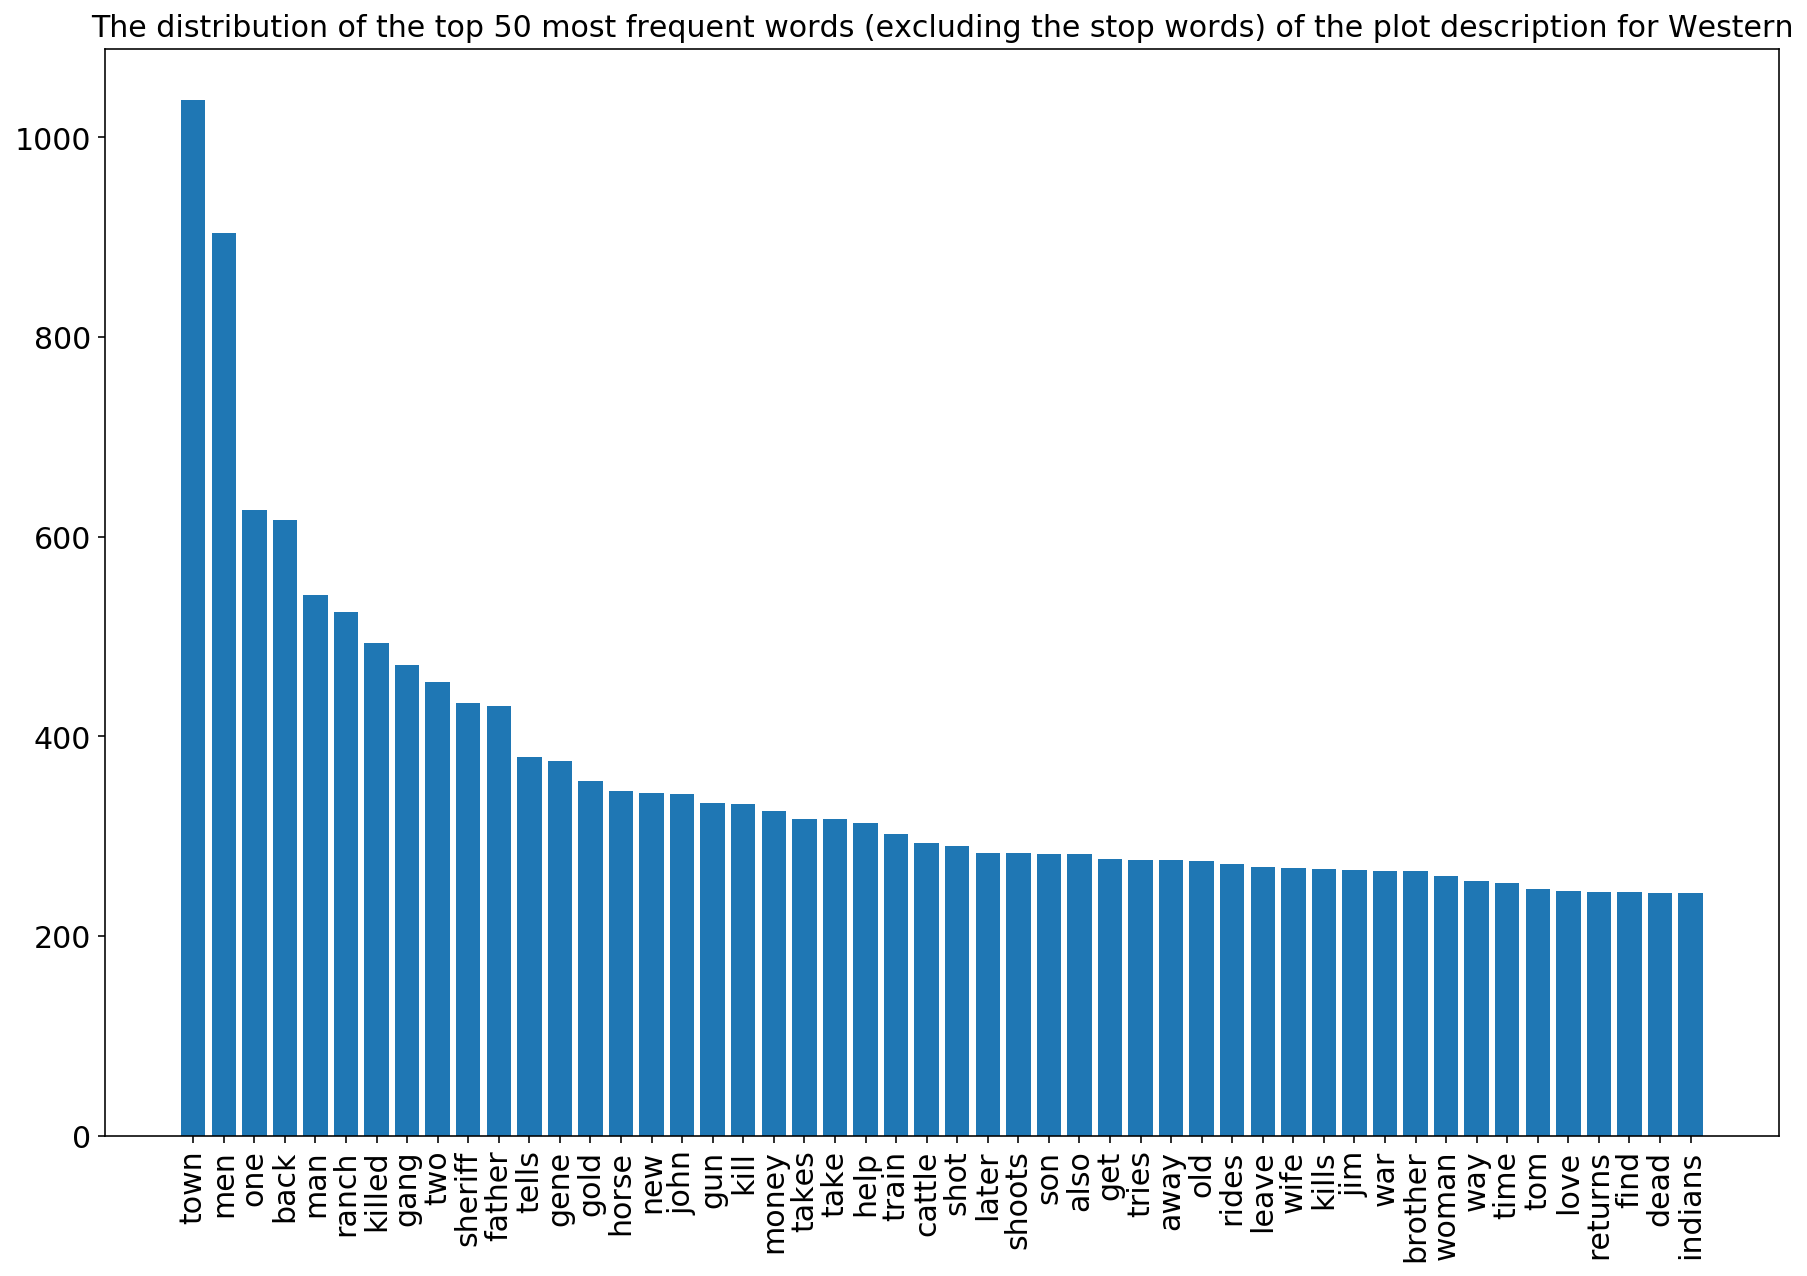

In [44]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',western_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Western', fontsize=15)
plt.xticks(rotation=90)
plt.show()

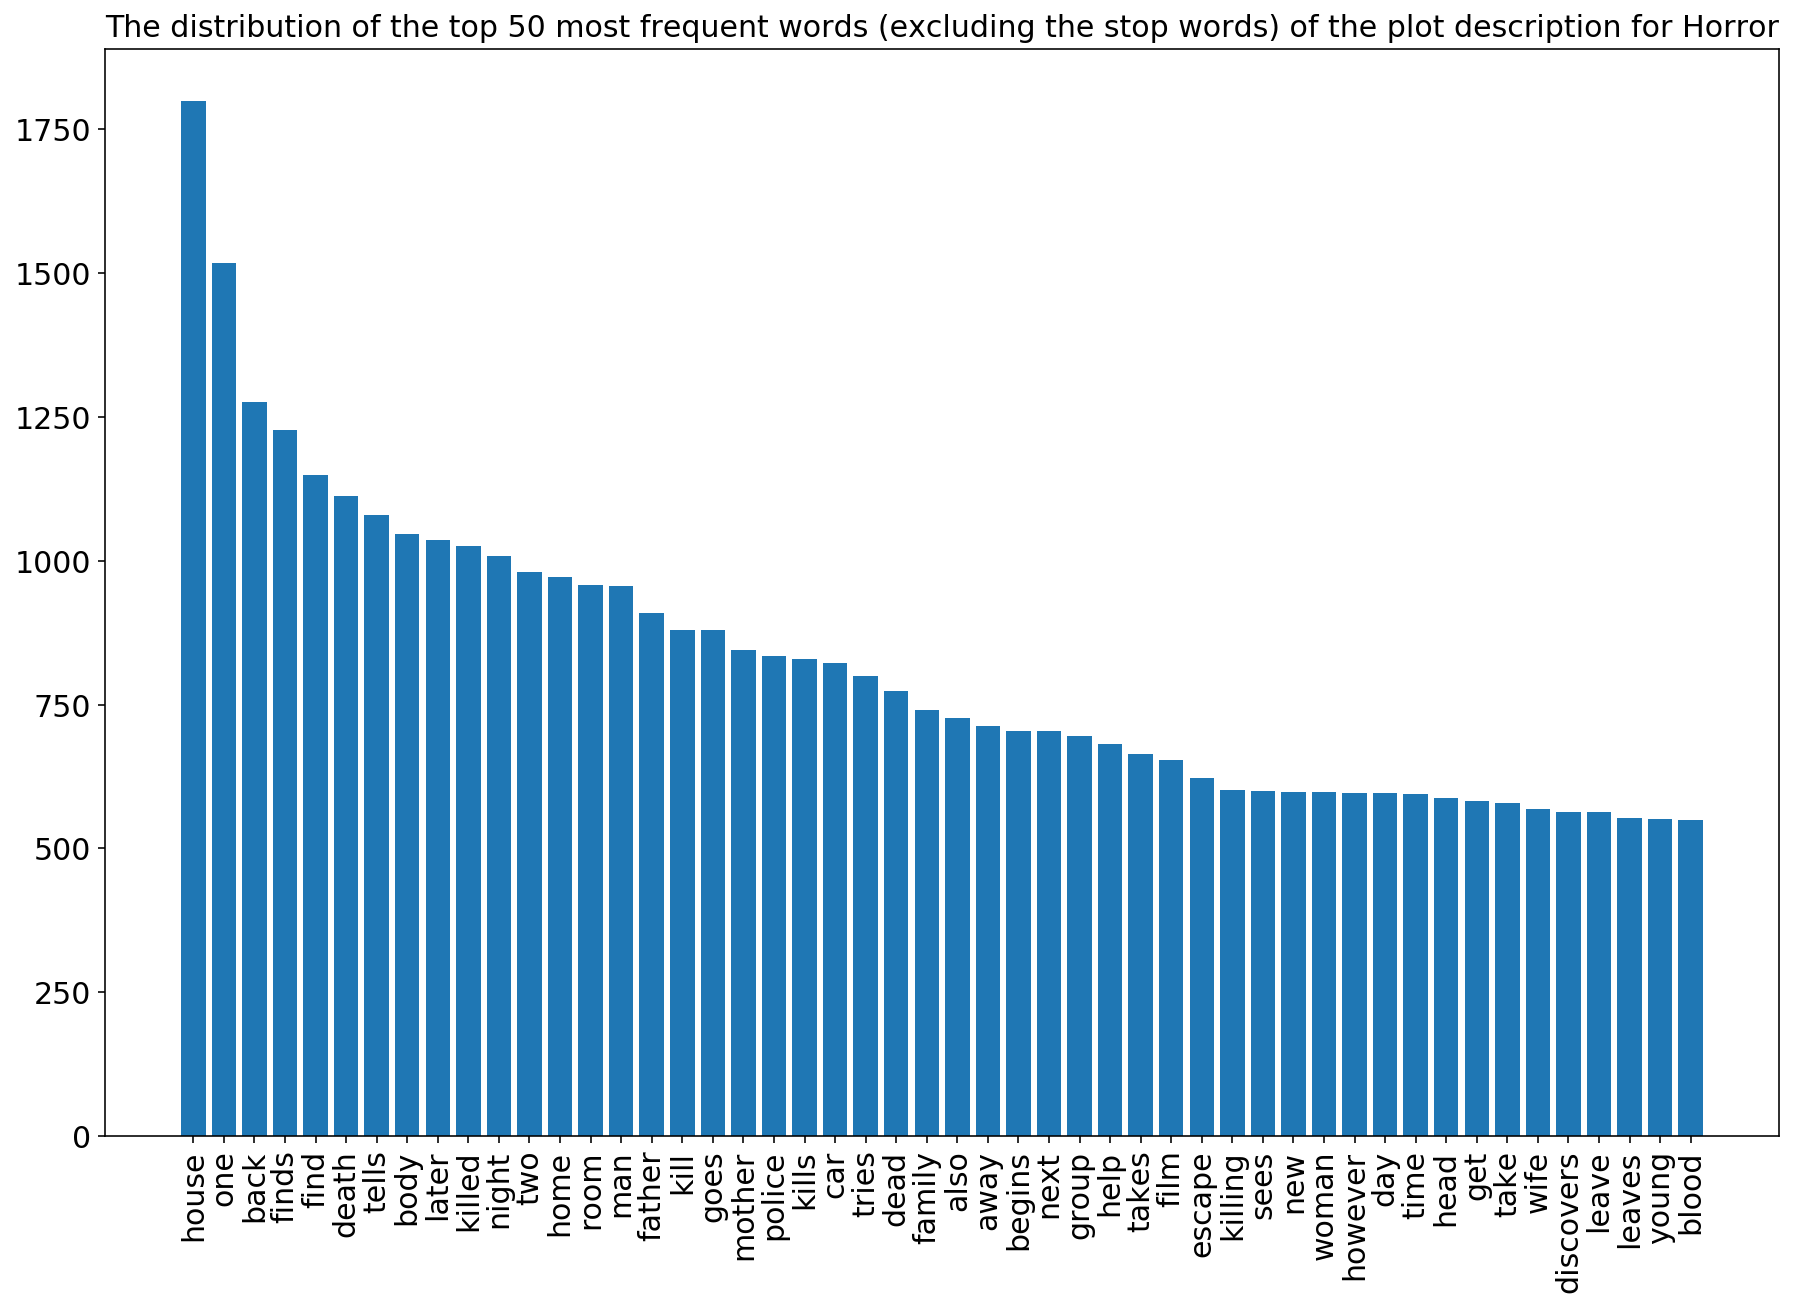

In [45]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',horror_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Horror', fontsize=15)
plt.xticks(rotation=90)
plt.show()

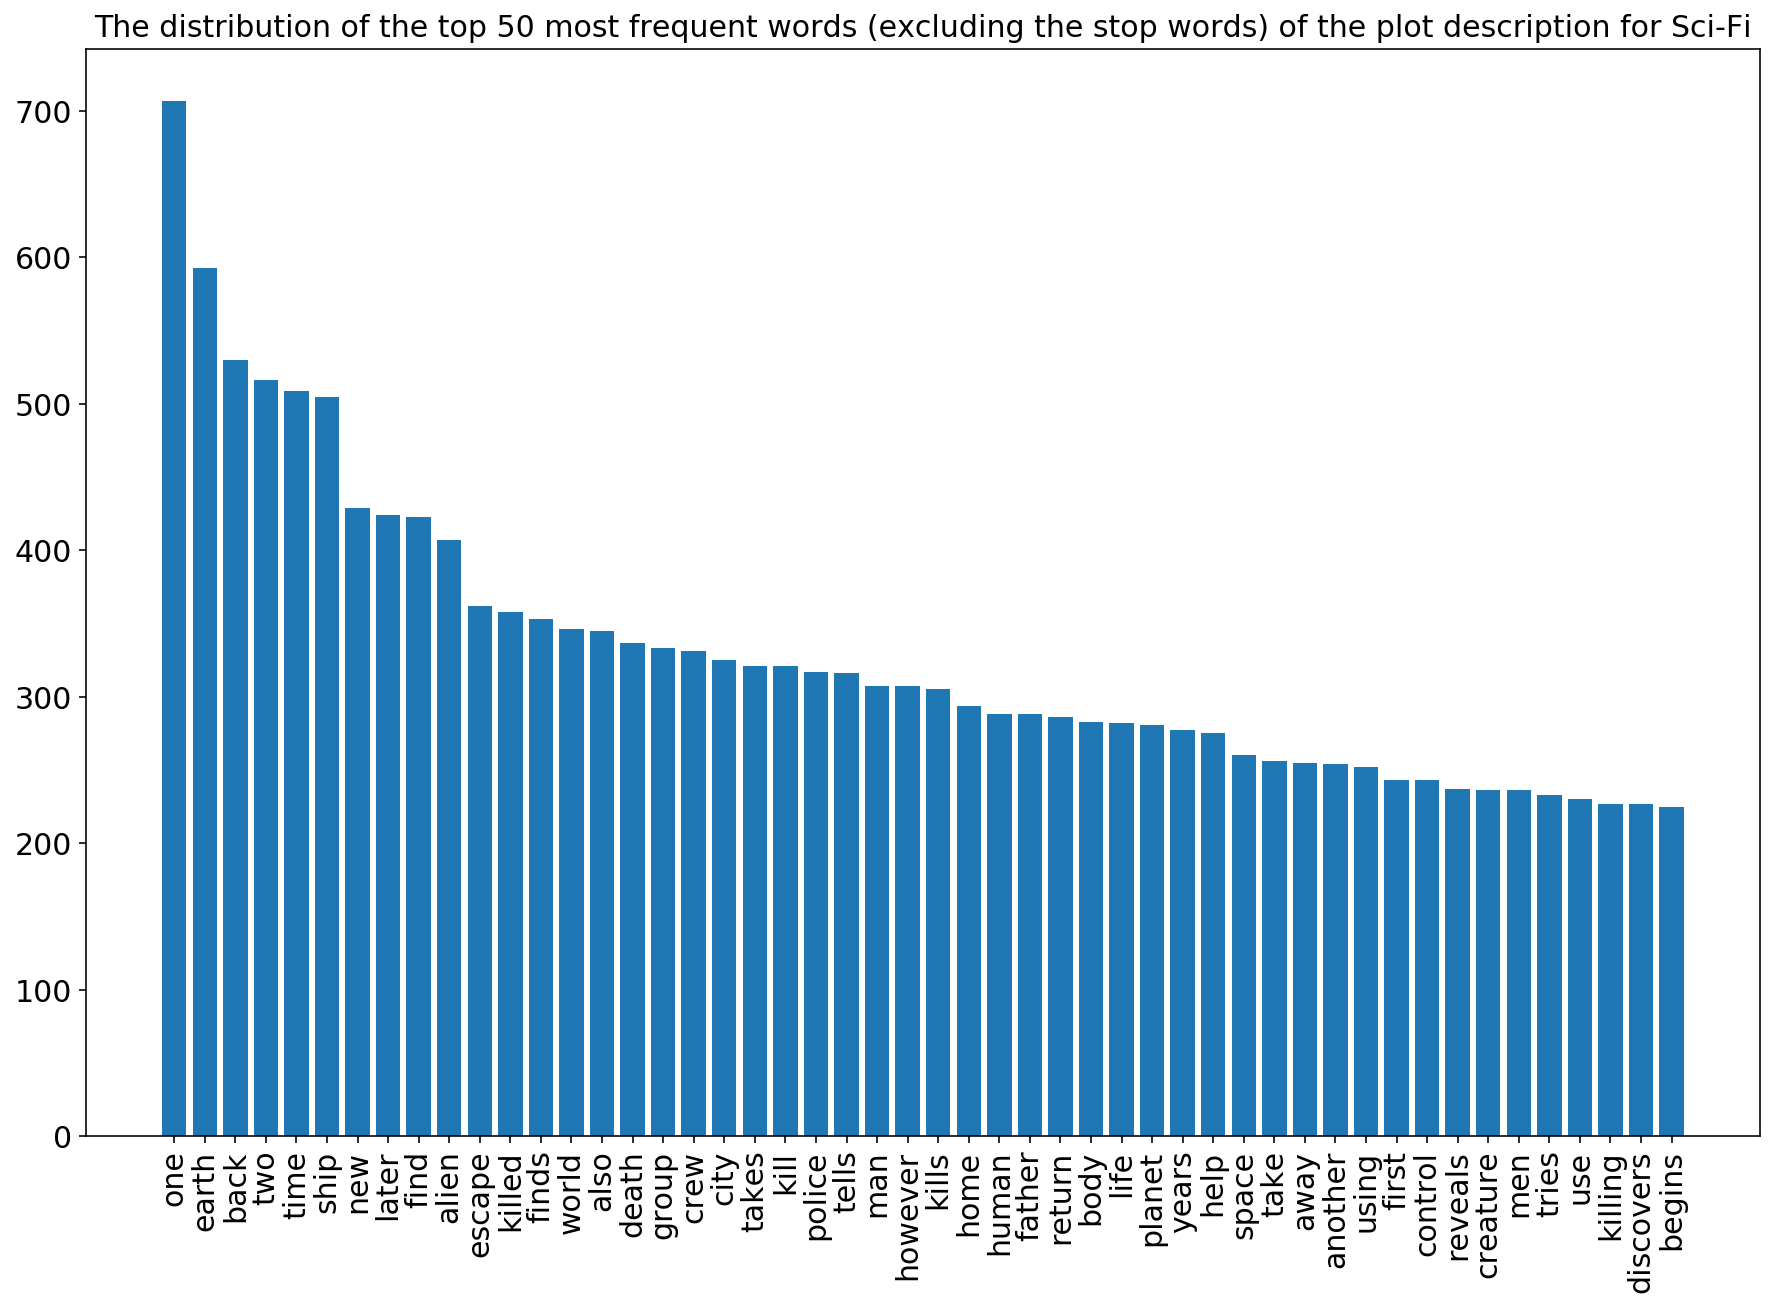

In [46]:
# bar plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.size"] = 15
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

top_list = np.asarray(top_n_words(50,'Plot',scifi_df))

plt.bar(top_list[:,0], np.array(top_list[:,1]).astype(float))
plt.title('The distribution of the top 50 most frequent words (excluding the stop words) of the plot description for Sci-Fi', fontsize=15)
plt.xticks(rotation=90)
plt.show()

### Calculate vocabulary alignments between the genres. 
Vocabularies alignment is defined as the percentage of the top 1000 most frequent words from one corpus
present in the top 1000 most frequent words of another corpus. We would like to see how similar the plot is, which can also verify how good our similarity matching results are.

In [47]:
top_1k_drama = np.asarray(top_n_words(1000,'Plot',drama_df))
top_1k_comedy = np.asarray(top_n_words(1000,'Plot',comedy_df))
top_1k_adventure = np.asarray(top_n_words(1000,'Plot',adventure_df))
top_1k_romance = np.asarray(top_n_words(1000,'Plot',romance_df))
top_1k_western = np.asarray(top_n_words(1000,'Plot',western_df))
top_1k_horror = np.asarray(top_n_words(1000,'Plot',horror_df))
top_1k_scifi = np.asarray(top_n_words(1000,'Plot',scifi_df))

In [48]:
top_1k_drama_words = top_1k_drama[:,0].tolist()
top_1k_comedy_words = top_1k_comedy[:,0].tolist()
top_1k_adventure_words = top_1k_adventure[:,0].tolist()
top_1k_romance_words = top_1k_romance[:,0].tolist()
top_1k_western_words = top_1k_western[:,0].tolist()
top_1k_horror_words = top_1k_horror[:,0].tolist()
top_1k_scifi_words = top_1k_scifi[:,0].tolist()

In [49]:
print('vocab alignment between drama and comedy is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_comedy_words)))/10))
print('vocab alignment between drama and adventure is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_adventure_words)))/10))
print('vocab alignment between drama and romance is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_romance_words)))/10))
print('vocab alignment between drama and western is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_western_words)))/10))
print('vocab alignment between drama and horror is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_horror_words)))/10))
print('vocab alignment between drama and sci-fi is: %.2f percent.' %((len(set(top_1k_drama_words) & set(top_1k_scifi_words)))/10))

vocab alignment between drama and comedy is: 83.60 percent.
vocab alignment between drama and adventure is: 64.80 percent.
vocab alignment between drama and romance is: 72.90 percent.
vocab alignment between drama and western is: 61.70 percent.
vocab alignment between drama and horror is: 65.50 percent.
vocab alignment between drama and sci-fi is: 61.60 percent.


In [50]:
print('vocab alignment between comedy and adventure is: %.2f percent.' %((len(set(top_1k_comedy_words) & set(top_1k_adventure_words)))/10))
print('vocab alignment between comedy and romance is: %.2f percent.' %((len(set(top_1k_comedy_words) & set(top_1k_romance_words)))/10))
print('vocab alignment between comedy and western is: %.2f percent.' %((len(set(top_1k_comedy_words) & set(top_1k_western_words)))/10))
print('vocab alignment between comedy and horror is: %.2f percent.' %((len(set(top_1k_comedy_words) & set(top_1k_horror_words)))/10))
print('vocab alignment between comedy and sci-fi is: %.2f percent.' %((len(set(top_1k_comedy_words) & set(top_1k_scifi_words)))/10))

vocab alignment between comedy and adventure is: 63.90 percent.
vocab alignment between comedy and romance is: 69.40 percent.
vocab alignment between comedy and western is: 61.30 percent.
vocab alignment between comedy and horror is: 65.90 percent.
vocab alignment between comedy and sci-fi is: 60.60 percent.


In [51]:
print('vocab alignment between adventure and romance is: %.2f percent.' %((len(set(top_1k_adventure_words) & set(top_1k_romance_words)))/10))
print('vocab alignment between adventure and western is: %.2f percent.' %((len(set(top_1k_adventure_words) & set(top_1k_western_words)))/10))
print('vocab alignment between adventure and horror is: %.2f percent.' %((len(set(top_1k_adventure_words) & set(top_1k_horror_words)))/10))
print('vocab alignment between adventure and scifi is: %.2f percent.' %((len(set(top_1k_adventure_words) & set(top_1k_scifi_words)))/10))

vocab alignment between adventure and romance is: 53.60 percent.
vocab alignment between adventure and western is: 61.20 percent.
vocab alignment between adventure and horror is: 59.90 percent.
vocab alignment between adventure and scifi is: 64.00 percent.


In [52]:
print('vocab alignment between romance and western is: %.2f percent.' %((len(set(top_1k_romance_words) & set(top_1k_western_words)))/10))
print('vocab alignment between romance and horror is: %.2f percent.' %((len(set(top_1k_romance_words) & set(top_1k_horror_words)))/10))
print('vocab alignment between romance and sci-fi is: %.2f percent.' %((len(set(top_1k_romance_words) & set(top_1k_scifi_words)))/10))

vocab alignment between romance and western is: 51.00 percent.
vocab alignment between romance and horror is: 53.70 percent.
vocab alignment between romance and sci-fi is: 49.80 percent.


In [53]:
print('vocab alignment between western and horror is: %.2f percent.' %((len(set(top_1k_western_words) & set(top_1k_comedy_words)))/10))
print('vocab alignment between western and sci-fi is: %.2f percent.' %((len(set(top_1k_western_words) & set(top_1k_comedy_words)))/10))
print('vocab alignment between horror and sci-fi is: %.2f percent.' %((len(set(top_1k_horror_words) & set(top_1k_scifi_words)))/10))

vocab alignment between western and horror is: 61.30 percent.
vocab alignment between western and sci-fi is: 61.30 percent.
vocab alignment between horror and sci-fi is: 63.50 percent.


By observing the vocabulary alignment between corpuses, we can see that

### Text normalization and feature engineering

We would like to first use stemming because it is simpler and also effective in striping down nouns. However, stemming could cause problems with verbs and adjectives where the word cannot retain their cannonical form. Therefore we want to use lemmatization to get proper meaning words after doing part-of-speech tagging.

In [54]:
movies_df_pos = movies_cleaned_df.copy()

In [55]:
#Perform part-of-speech tagging on the raw data
for p in range(len(movies_df_pos['Plot'])):
    plot = movies_df_pos['Plot'][p]
    # convert to lower case
    plot = plot.lower()
    # word tokenize
    plot = word_tokenize(plot)
    # Assign tags to words
    movies_df_pos['Plot'][p] = nltk.pos_tag(plot)

C:\Users\Katherine Lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [56]:
movies_df_pos['Plot'].head()

0    [(beautiful, JJ), (summer, NN), (day, NN), (fa...
1    [(thug, NN), (accosts, NNS), (girl, VBP), (she...
2    [(prints, NNS), (the, DT), (first, JJ), (ameri...
3    [(rejected, VBN), (admirer, JJ), (sets, NNS), ...
4    [(john, NN), (wharton, VBZ), (the, DT), (husba...
Name: Plot, dtype: object

In [57]:
lemmmatizer=WordNetLemmatizer()

for p in range(len(movies_df_pos['Plot'])):
    plot = movies_df_pos['Plot'][p]
    
    # select nouns and adjectives to do lemmatizing
    plot = [w[0] for w in plot if w[1] in ['NN','NNS','NNP','NNPS', 'JJ', 'JJR', 'JJS']]
    # remove stopwords
    plot = [w for w in plot if w not in set(stopwords.words('english'))]
    # remove numbers and other non-letter characters
    plot = [w for w in plot if w.isalpha()]
    # perform lemmatization
    plot = [lemmmatizer.lemmatize(w) for w in plot]
    # list to str
    plot = " ".join(plot)

    movies_df_pos['Plot'][p] = plot

C:\Users\Katherine Lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
drama_lemmed_noun = pd.DataFrame()
comedy_lemmed_noun = pd.DataFrame()
romance_lemmed_noun = pd.DataFrame()
adventure_lemmed_noun = pd.DataFrame()
western_lemmed_noun = pd.DataFrame()

for i in range(len(movies_df_pos['Genre'])):
    if movies_df_pos['Genre'][i] == 'comedy':
        comedy_lemmed_noun = comedy_lemmed_noun.append(movies_df_pos.iloc[i,:])
    elif movies_df_pos['Genre'][i] == 'drama':
        drama_lemmed_noun = drama_lemmed_noun.append(movies_df_pos.iloc[i,:])
    elif movies_df_pos['Genre'][i] == 'adventure':
        adventure_lemmed_noun = adventure_lemmed_noun.append(movies_df_pos.iloc[i,:])
    elif movies_df_pos['Genre'][i] == 'romance':
        romance_lemmed_noun = romance_lemmed_noun.append(movies_df_pos.iloc[i,:])
    elif movies_df_pos['Genre'][i] == 'western':
        western_lemmed_noun = western_lemmed_noun.append(movies_df_pos.iloc[i,:])
    else:
        None

#### Convert the corpus into a bag-of-words tf-idf weighted vector representation.
Here we convert the corpus into a bag-of-words tf-idf weighted vector representation for each genre. We can observe from the result on how much information each of the words gives in a specific genre. The lower the IDF value of a word, the less unique it is to any particular document.

In [59]:
# function converting corpus into a bag-of-words tf-idf weighted vector

def idf_weights(lemmed):
    # instantiate CountVectorizer()
    cv = CountVectorizer(stop_words = 'english')
    # generate word counts for the words in your lemmed corpus
    word_count_vector=cv.fit_transform(lemmed)

    #TF-IDF
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
    df_idf = df_idf.sort_values(by=["idf_weights"],ascending=True)
    
    return df_idf


def tfidf_score(lemmed):
 
    # settings that you use for count vectorizer will go here
    tfidf_vectorizer=TfidfVectorizer(use_idf=True)

    # just send in all your docs here
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(lemmed)

    # get the first vector out (for the first document)
    first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

    # place tf-idf values in a pandas data frame
    df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tf-idf"])
    df = df.sort_values(by=["tf-idf"],ascending=False)
    
    return df

In [60]:
idf_weights(comedy_lemmed_noun.Plot.values.tolist()).head(10)

,idf_weights
new,2.044748
friend,2.101504
time,2.123955
day,2.191327
life,2.226249
home,2.238350
man,2.307066
way,2.356272
film,2.376398
father,2.381494


In [61]:
tfidf_score(comedy_lemmed_noun.Plot.values.tolist()).head(10)

,tf-idf
crockery,0.570765
suburb,0.383583
quiet,0.343891
violent,0.339097
arrest,0.288524
wrong,0.263082
thing,0.204325
family,0.164412
wife,0.162241
film,0.157002


### Build a model to predict movie genres

#### Mutinomial Naive Bayes

In [62]:
# get categorical classification dataset
Train_X, Test_X, Train_Y, Test_Y = train_test_split(movies_df_pos['Plot'],movies_df_pos['Genre'],test_size=0.3)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(movies_df_pos['Plot'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [63]:
# Classifier - MultinomialNB
Naive = MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  57.63537202960654


##### Classification Report

In [64]:
print(classification_report(Test_Y, predictions_NB))

              precision    recall  f1-score   support

   adventure       1.00      0.10      0.19       230
      comedy       0.57      0.70      0.63      1856
       drama       0.54      0.71      0.61      1849
      horror       0.79      0.28      0.41       410
     romance       0.50      0.15      0.23       335
       scifi       0.80      0.22      0.35       162
     western       0.90      0.43      0.58       292

    accuracy                           0.58      5134
   macro avg       0.73      0.37      0.43      5134
weighted avg       0.62      0.58      0.55      5134



##### Confusion Matrix

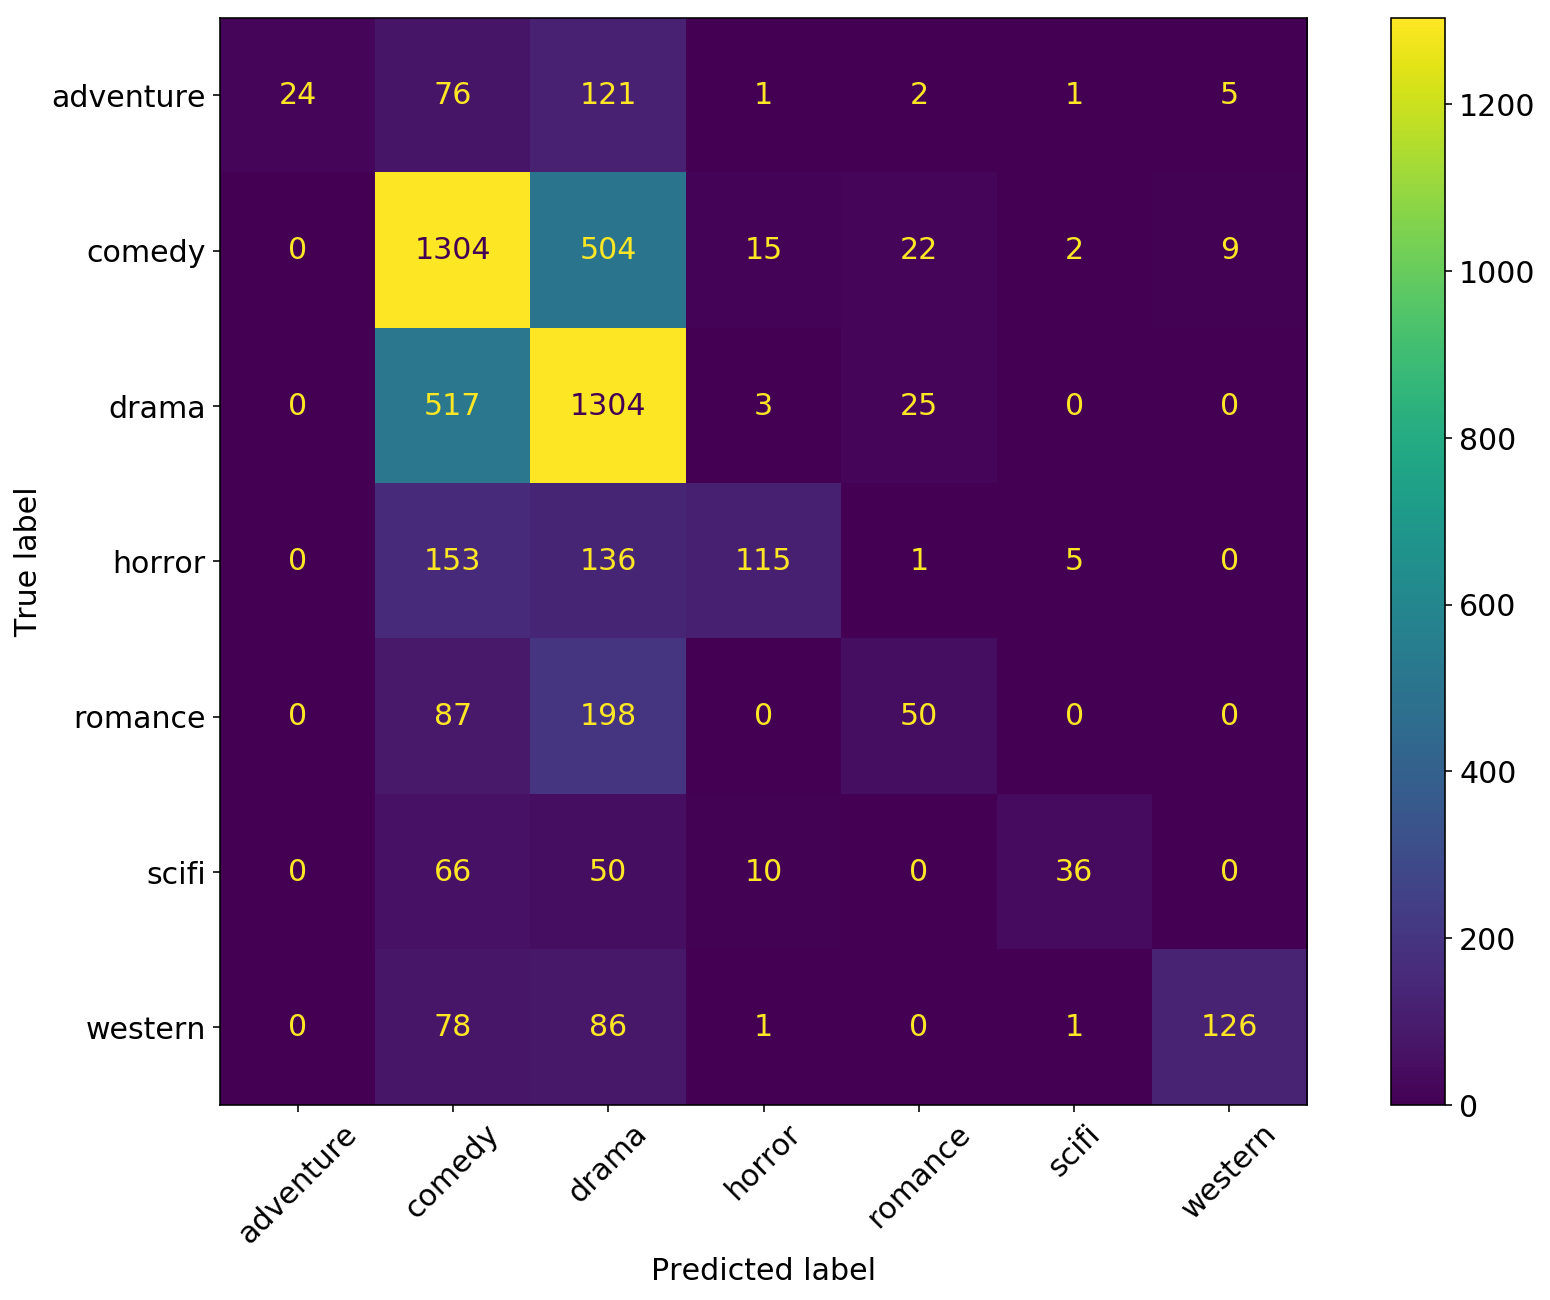

In [65]:
plot_confusion_matrix(Naive, Test_X_Tfidf, Test_Y)  # doctest: +SKIP
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

##### Learning Curve for MutinomialNB Model

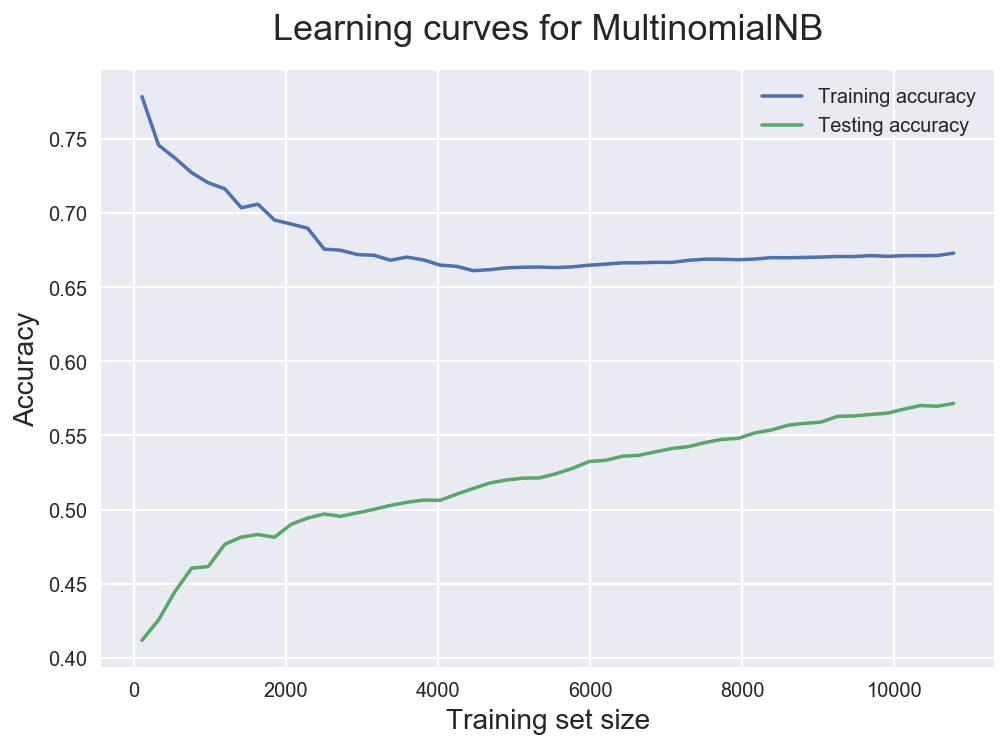

In [66]:
train_sizes = np.linspace(0.01, 1.0, 50)
train_sizes, train_scores, test_scores = learning_curve(Naive, Train_X_Tfidf, Train_Y, 
                                                        train_sizes = train_sizes, cv = 10, 
                                                        scoring = 'accuracy')
train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1)

#plot
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_scores_mean, label = 'Testing accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for MultinomialNB', fontsize = 18, y = 1.03)
plt.legend()

#### Use Pipeline with SVM

In [67]:
# create a snowball stemmer for English text that does not stem stopwords
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# create a class to vectorize stemmed text by frequency counts
class StemmedCountVectorizer(CountVectorizer):
    # function to create an analyzer function
    def build_analyzer(self):
        # initialize CountVectorizer and call build_analyzer on it
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        # return a function that stems each token of input and counts
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# create an instance of the StemmedCountVectorizer using English stopwords
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

# create a pipeline to take the results of the StemmedCountVectorizer (the stem frequency)
# pass it to a TfidfTransformer to calculate tf-idf weighting, and pass that to a
# SVC to train the classifier on the vectorized corpus.
text_svc_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('svc', SVC())])

# fit the model to the data
text_svc_stemmed = text_svc_stemmed.fit(Train_X, Train_Y)
# predict on new data
predicted_svc_stemmed = text_svc_stemmed.predict(Test_X)

# output performace metrics 
print(classification_report(Test_Y, predicted_svc_stemmed))

              precision    recall  f1-score   support

   adventure       0.85      0.12      0.21       230
      comedy       0.59      0.72      0.65      1856
       drama       0.57      0.72      0.63      1849
      horror       0.81      0.42      0.55       410
     romance       0.59      0.09      0.15       335
       scifi       0.84      0.28      0.42       162
     western       0.89      0.62      0.73       292

    accuracy                           0.61      5134
   macro avg       0.73      0.42      0.48      5134
weighted avg       0.64      0.61      0.58      5134



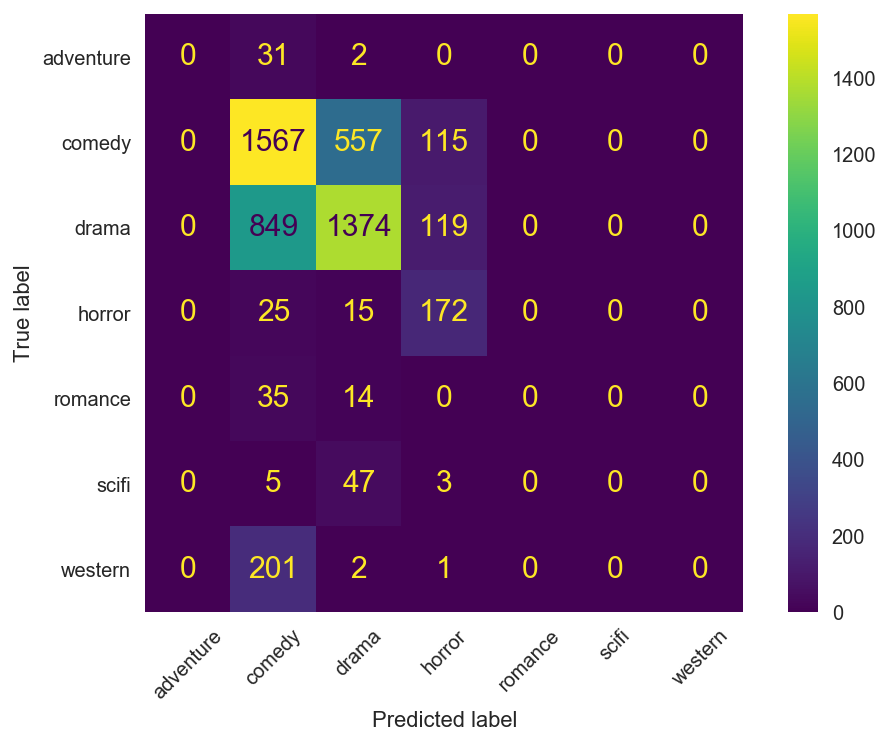

In [68]:
plot_confusion_matrix(text_svc_stemmed, Test_Y, predicted_svc_stemmed)  # doctest: +SKIP
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

### Fixing Class Imbalance

#### Undersampling
Here we choose undersampling because the variance in the proportion of the datasets for each genre. If over sampling is used, we suspect the data quality will be compromised due to the generated fake data. Also smaller dataset will fit Multinomial Naive Bayes model better.

In [69]:
undersampling_df = movies_cleaned_df.copy()
undersampling_df

,Year,Origin,Genre,Plot,Plot Language
0,1908,American,drama,beautiful summer day father and mother take...,en
1,1908,American,drama,thug accosts girl she leaves her workplace ...,en
2,1908,American,drama,prints the first American film adaptation ...,en
3,1909,American,drama,rejected admirer sets trap kill his sweeth...,en
4,1909,American,drama,John Wharton the husband true and trusting w...,en
...,...,...,...,...,...
17108,2007,Russian,scifi,Future soft drugs are legalized Bowling Olymp...,en
17109,2008,Russian,scifi,shows four century treasure seekers who trav...,en
17110,2008,Russian,scifi,Year Maxim Kammerer Stepanov space explorer ...,en
17111,2009,Russian,scifi,Alisa Selezneva joins archeological expeditio...,en


In [70]:
balanced_df = movies_cleaned_df.groupby('Genre',as_index = False,group_keys=False).apply(lambda s: s.sample(551,replace=True))

In [71]:
balanced_df = balanced_df.reset_index(drop=True)

In [72]:
balanced_genre_df = pd.DataFrame((balanced_df.Genre.value_counts()/len(balanced_df))*100)
balanced_genre_df = balanced_genre_df.rename(columns = {'Genre':'Proportion'})
balanced_genre_df.head()

,Proportion
western,14.285714
scifi,14.285714
drama,14.285714
romance,14.285714
horror,14.285714


### Repeat modelling after fixing class imbalance

#### Multinomial Naive Bayes

In [73]:
Trainb_X, Testb_X, Trainb_Y, Testb_Y = train_test_split(balanced_df['Plot'],balanced_df['Genre'],test_size=0.3)

In [74]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(movies_df_pos['Plot'])
Trainb_X_Tfidf = Tfidf_vect.transform(Trainb_X)
Testb_X_Tfidf = Tfidf_vect.transform(Testb_X)

# Classifier - MultinomialNB
Naive = MultinomialNB()
Naive.fit(Trainb_X_Tfidf,Trainb_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Testb_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Testb_Y)*100)

Naive Bayes Accuracy Score ->  67.27115716753022


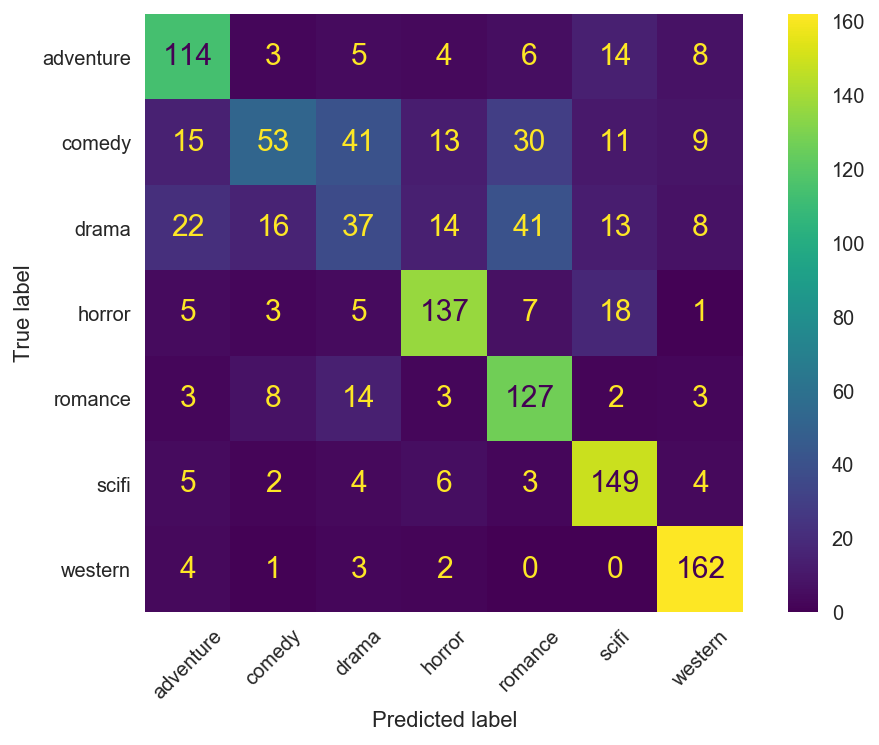

In [75]:
plot_confusion_matrix(Naive, Testb_X_Tfidf, Testb_Y)  # doctest: +SKIP
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

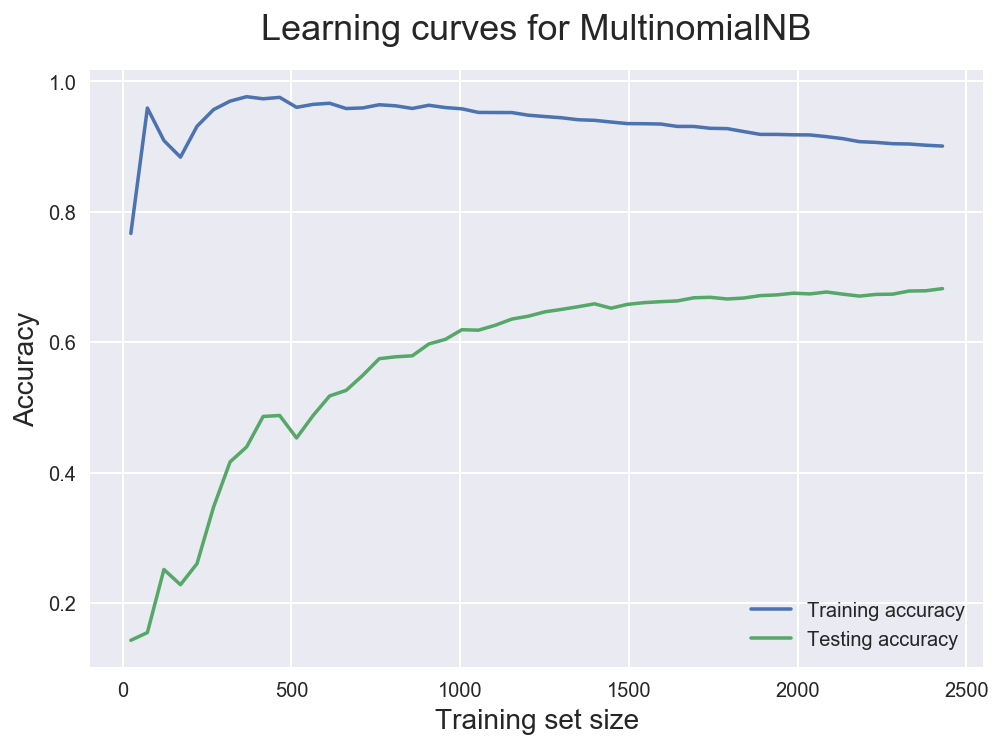

In [76]:
train_sizes = np.linspace(0.01, 1.0, 50)
train_sizes, train_scores, test_scores = learning_curve(Naive, Trainb_X_Tfidf, Trainb_Y, 
                                                        train_sizes = train_sizes, cv = 10, 
                                                        scoring = 'accuracy')
train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1)

#plot
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_scores_mean, label = 'Testing accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for MultinomialNB', fontsize = 18, y = 1.03)
plt.legend()

#### Pipeline with SVM

In [77]:
text_svc_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('svc', SVC())])

# fit the model to the data
text_svc_stemmed = text_svc_stemmed.fit(Trainb_X, Trainb_Y)
# predict on new data
predicted_svc_stemmed = text_svc_stemmed.predict(Testb_X)

# output performace metrics 
print(classification_report(Testb_Y, predicted_svc_stemmed))

              precision    recall  f1-score   support

   adventure       0.86      0.68      0.76       154
      comedy       0.56      0.44      0.50       172
       drama       0.36      0.62      0.46       151
      horror       0.85      0.85      0.85       176
     romance       0.75      0.72      0.74       160
       scifi       0.92      0.80      0.85       173
     western       0.95      0.90      0.92       172

    accuracy                           0.72      1158
   macro avg       0.75      0.71      0.72      1158
weighted avg       0.76      0.72      0.73      1158



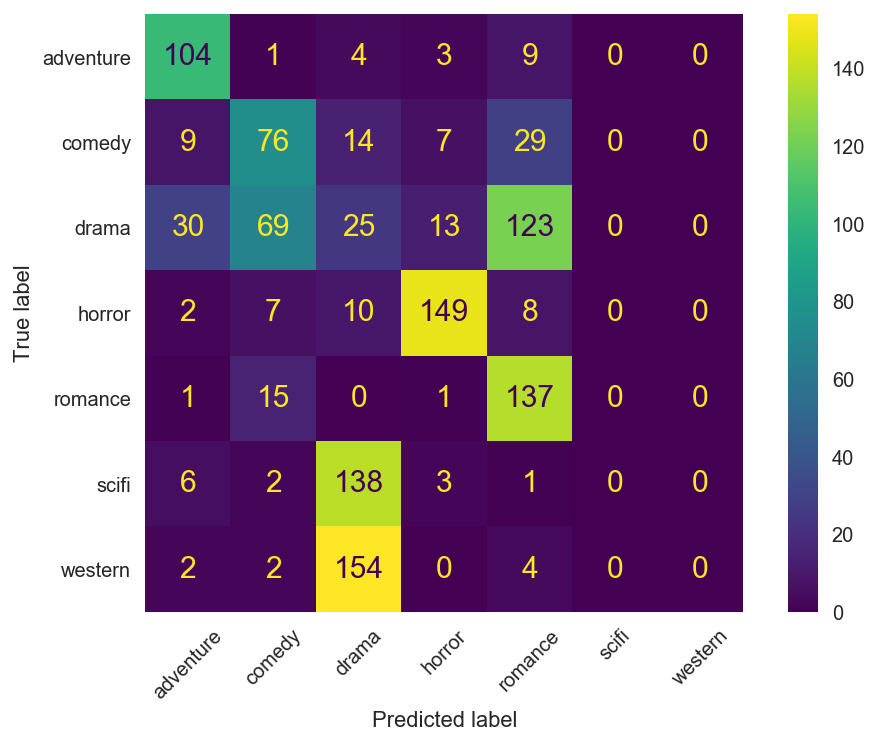

In [78]:
plot_confusion_matrix(text_svc_stemmed, Testb_Y, predicted_svc_stemmed)  # doctest: +SKIP
plt.xticks(rotation=45)
plt.grid(False)
plt.show()